In [1]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import re
from scipy import interpolate
import manipulate_text as mt
import copy
import itertools
import argparse
import numpy.ma as ma
from scipy.optimize import minimize, fsolve
import time
from scipy.stats import norm

In [2]:
#define relevant paths and names
#script_path = os.path.realpath(__file__) if a .py is run
script_path = os.getcwd()
base_path =  script_path.split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'

In [3]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW 

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def gen_fake_data(beam_cut, frac, sigma_rms, sigma_BW, N, n, dlt_N, dlt_n):
    num_beams = beam_cut+1
    
    #create coords for data
    ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
    AX_N, AX_n = np.meshgrid(ax_N, ax_n)
    
    #create coords for sources
    dlt_N_source = dlt_N/frac
    dlt_n_source = dlt_N_source
    fov_N = N*dlt_N
    print('fov N: ' + str(fov_N))
    fov_n = n*dlt_n
    print('fov n: ' + str(fov_n))
    fov_N_source = fov_N+2*num_beams*sigma_BW
    print('fov N source: ' + str(fov_N_source))
    fov_n_source = fov_n+2*num_beams*sigma_BW
    print('fov n source: ' + str(fov_n_source))
    N_source = int(np.round(fov_N_source/dlt_N_source))
    print('N source: ' + str(N_source))
    n_source = int(np.round(fov_n_source/dlt_n_source))
    print('n source: ' + str(n_source))
    fov_N_source = N_source*dlt_N_source
    fov_n_source = n_source*dlt_n_source
    ax_N_source, ax_n_source = make_coords(N_source, n_source, dlt_N_source, dlt_n_source)
    AX_N_SOURCE, AX_n_SOURCE = np.meshgrid(ax_N_source, ax_n_source)
    #smaller rms noise in the central lxb region where l and b are in degrees
    l = 2/3
    b = 2/3
    outside = np.logical_or(np.abs(AX_N_SOURCE)>(l/2)*np.pi/180, np.abs(AX_n_SOURCE)>(b/2)*np.pi/180)
    inside = np.logical_not(outside)
    noise = sigma_rms[-1]*outside + sigma_rms[0]*inside
    #generate fake data
    z = np.random.normal(size=(n_source, N_source))
    data_gen = 0*AX_N
    for i in range(n_source):
        for j in range(N_source):
            loc = (ax_n_source[i], ax_N_source[j])
            start_N = np.searchsorted(ax_N, loc[1]-beam_cut*sigma_BW, side='left')
            end_N = np.searchsorted(ax_N, loc[1]+beam_cut*sigma_BW, side='left')
            start_n = np.searchsorted(ax_n, loc[0]-beam_cut*sigma_BW, side='left')
            end_n = np.searchsorted(ax_n, loc[0]+beam_cut*sigma_BW, side='left')
            beam = dlt_N_source*noise[i,j]/(np.sqrt(np.pi)*sigma_BW)*z[i, j] \
                *np.exp(-((AX_N[start_n:end_n, start_N:end_N]-ax_N_source[j])**2+(AX_n[start_n:end_n, start_N:end_N]-ax_n_source[i])**2)/(2*sigma_BW**2))
            data_gen[start_n:end_n, start_N:end_N] += beam
    return data_gen, AX_N, AX_n

def gen_templates(run, nu_data, omega_beam, AX_N, AX_n):
    n, N = AX_N.shape
    #bring in variables from the run
    DA = run['DA']
    txt_file_name = run['file_name']
    nrho = run['nrho']
    nnu = run['nnu']
    sigmav_bench = run['sigma_v']
    rho_range = run['rho_range']
    nu_range = run['nu_range']
    
    #process run variables
    array_file_name = txt_file_name.split('_info')[0] + '.npy'
    m = re.search('[0-9]{4}_', array_file_name)
    out_type = array_file_name.split('.npy')[0].split(m.group(0))[-1]
    nu_v = np.logspace(np.log10(nu_range[0]), np.log10(nu_range[1]), nnu)
    rho_v = np.linspace(rho_range[0], rho_range[1], nrho)
    theta_v = np.arcsin(rho_v/np.sqrt(rho_v**2+DA**2))
    thetatheta, nunu = np.meshgrid(theta_v, nu_v)
    
    #load flux and change units
    nu_dSdth = np.load(base_path + out_type + '/' + array_file_name) #erg cm^-2 s^-1 rad^-1
    dS_dnudOmega = ((10**26/nunu)*nu_dSdth/(2*np.pi*np.sin(thetatheta))).astype(np.float64) #mJy/Sr
    rho_v_low = np.linspace(0, rho_range[0], 5)
    theta_v_low = np.arcsin(rho_v_low/np.sqrt(rho_v_low**2+DA**2))
    thetatheta_low, nunu_low = np.meshgrid(theta_v_low, nu_v)
    flux_low = 0*thetatheta_low
    
    #find max synch frequency index and extrapolate to rho=0
    delta_theta = (theta_v[1]-theta_v[0])/100
    domain = min(5,len(theta_v))
    for i in range(dS_dnudOmega.shape[0]):
        zs = np.where(dS_dnudOmega[i] == 0)[0]
        if len(zs) == nrho:
            nu_fin_ind = i #max frequency index + 1
            break
        else:
            for elem in zs:
                dS_dnudOmega[i, elem] = 1e-300
            oned_interp_nu = interpolate.interp1d(theta_v[0:domain], dS_dnudOmega[i][0:domain], kind = 'cubic')
            f_pr = (oned_interp_nu(theta_v[0]+delta_theta) - oned_interp_nu(theta_v[0]))/delta_theta
            f_prpr = f_pr/theta_v[0]
            f_0 = oned_interp_nu(theta_v[0])-f_prpr*theta_v[0]**2/2
            flux_low[i] = f_0+f_prpr*theta_v_low**2/2
    #combine low rho solution with main solution
    dS_dnudOmega_extrap = np.hstack((flux_low[:, :-1], dS_dnudOmega))
    theta_v_extrap = np.hstack((theta_v_low[:-1], theta_v))
    
    ln_dS_dnudOmega_extrap = np.log(dS_dnudOmega_extrap[0:nu_fin_ind])
    ln_dS_dnudOmega_interp = interpolate.interp2d(theta_v_extrap, nu_v[0:nu_fin_ind], ln_dS_dnudOmega_extrap[0:nu_fin_ind], kind='cubic')
    
    def dS_dnudOmega_cart(th_x, th_y, nu):
        return np.exp(ln_dS_dnudOmega_interp(np.sqrt(th_x**2+th_y**2), nu))
    
    #generate expected signal flux per beam in each pixel. The real way to do this is
    #to convolve real signal with beam using sig_meas function. This is slow and after testing
    #on a few points it seems that dS_dndOmega*Omega_beam is a good approximation.
    signal_beam = np.zeros((n,N)) 
    for i in range(signal_beam.shape[0]):
        for j in range(signal_beam.shape[1]):    
            signal_beam[i, j] = dS_dnudOmega_cart(AX_N[i, j], AX_n[i, j], nu_data)*omega_beam
    back_beam = np.ones((n, N))
    return signal_beam, back_beam

def sort_runs(mx_set, D0_set, args=None, rtrn='inds'):
    D0_vals = np.sort(np.unique(D0_set))
    ind_set = []
    for D0_val in D0_vals:
        ind_D0val = np.where(D0_set==D0_val)[0]
        p_D0val = np.argsort(mx_set[ind_D0val])
        ind_set.append(ind_D0val[p_D0val])
    ind_set_tup = tuple(ind_set)
    ind_full = np.hstack(ind_set_tup)
    if rtrn == 'inds':
        return ind_full
    elif rtrn == 'arrs':
        if args==None:
            return mx_set[ind_full], D0_set[ind_full]
        else:
            return mx_set[ind_full], D0_set[ind_full], tuple(args[i][ind_full] for i in range(len(args)))
        
#coords = (x, y)                                                                                                                                          
#ellipse_params = (r, a, thickness/2)  
def create_mask(THETA, th_range, ps_ind=None, rl=None, coords=None, ellipse_params=None, data=None,  sigma_rms=None, num_sigma_rms=None, sigma_BW=None, num_sigma_BW=None, dlt=None,\
 method='azimuthally_sym'):
    m0 = 0*THETA==0
    m1 = m0
    m2 = m0
    m3 = m0
    if ps_ind is not None:
        m0[ps_ind]=False
    if method=='azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
    elif method=='ellipse_and_azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+(ellipse_params[0]**2)*coords[1]**2)
        m2 = np.abs(elliptic_d-ellipse_params[1])>ellipse_params[2]
    if rl=='right':
        m3[np.where(AX_N>=0)] = False
    elif rl=='left':
        m3[np.where(AX_N<=0)] = False
    return m0*m1*m2*m3

def f(x, w):
    elliptic_d = np.sqrt(x[0]**2+w[2]**2*x[1]**2)
    return w[0]+w[1]*np.exp(-(elliptic_d-w[3])**2/(2*w[4]**2))

def chi2(w, *args):
    model = f(args[1], w)
    return np.sum(((args[0]-model)**2/args[2]**2)*args[3])

def find_test_stats(resid, signal, background, sigma_rms, mask, this_ws, this_dw, this_chi_sb_sb, sigmav, sigmav_bench=2.2e-26):
    this_w0b = this_ws
    this_chi_b_b = this_chi_sb_sb
    this_w0s = this_ws+(sigmav/sigmav_bench)*this_dw
    this_wb = this_ws-(sigmav/sigmav_bench)*this_dw
    this_chi_b_sb = np.sum(mask*(resid+(sigmav/sigmav_bench)*signal-this_w0s*background)**2/(sigma_rms**2))
    this_chi_sb_b = np.sum(mask*(resid-(sigmav/sigmav_bench)*signal-this_wb*background)**2/(sigma_rms**2))
    this_delta_chi_b = this_chi_sb_b-this_chi_b_b
    this_delta_chi_sb = this_chi_sb_sb-this_chi_b_sb 
    return this_ws, this_w0b, this_w0s, this_wb, this_chi_sb_b, this_chi_b_sb, this_delta_chi_b, this_delta_chi_sb

def remove_ps(data, THETA, cent, ann1, ann2, thresh):
    #find center index
    ind0 = np.where(THETA==0)
    indy0 = ind0[0][0]
    indx0 = ind0[1][0]

    #find indices of annulus
    ind_ann0 = np.where(np.logical_and(THETA>ann1, THETA<ann2))
    dlt_ind_ann = (ind_ann0[0]-indy0, ind_ann0[1]-indx0)

    #find indices of center
    ind_cent0 = np.where(THETA<cent)
    dlt_ind_cent = (ind_cent0[0]-indy0, ind_cent0[1]-indx0)
    
    #prepare for for-loops
    sh = data.shape
    mask_indx = []
    mask_indy = []
    
    #iterate over each pixel, putting the circle and annulus centered over the pixel and computing the average
    #intensity in each. If the circle has an average intensity larger than the annulus by a certain amount
    #then store the indices of the circle for masking
    for i in range(sh[0]):
        #print('i: ', i)
        for j in range(sh[1]):
            ind_of_ind = [k for k in range(len(dlt_ind_ann[0])) \
                                  if j+dlt_ind_ann[1][k] < N and j+dlt_ind_ann[1][k] >= 0\
                                 and i+dlt_ind_ann[0][k] < n and i+dlt_ind_ann[0][k] >= 0]
            ind_ann_x = [int(j+dlt_ind_ann[1][ind]) for ind in ind_of_ind]
            ind_ann_y = [int(i+dlt_ind_ann[0][ind]) for ind in ind_of_ind]
            num_ann = len(ind_of_ind)

            ind_of_ind_cent = [k for k in range(len(dlt_ind_cent[0])) \
                                  if j+dlt_ind_cent[1][k] < N and j+dlt_ind_cent[1][k] >= 0\
                                 and i+dlt_ind_cent[0][k] < n and i+dlt_ind_cent[0][k] >= 0]
            ind_cent_x = [int(j+dlt_ind_cent[1][ind]) for ind in ind_of_ind_cent]
            ind_cent_y = [int(i+dlt_ind_cent[0][ind]) for ind in ind_of_ind_cent]
            num_cent = len(ind_of_ind_cent)

            #compute average intensity in annulus and center
            I_center = np.sum(data[(ind_cent_y, ind_cent_x)])/num_cent
            I_ann = np.sum(data[(ind_ann_y, ind_ann_x)])/num_ann

            if I_center > thresh[i,j]+I_ann: #or I_center < I_ann-thresh[i,j]: (include if voids should be masked)
                mask_indy += list(ind_cent_y)
                mask_indx += list(ind_cent_x)
                
    #remove repeated pairs of indices from the list of indices
    mask_inds_raw = np.array([mask_indy, mask_indx])
    print('raw indices found')
    mask_inds = np.unique(mask_inds_raw, axis=1)
    
    #plot data with masked indices indicated with scatter points
    #plt.imshow(data)
    #plt.scatter(mask_inds[1], mask_inds[0], s=2, color='r')
    
    return tuple(mask_inds)

In [4]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')

real data info extracted


In [5]:
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
sigma_rms = [0.25, 0.3]
l = 2/3
b = 2/3
outside = np.logical_or(np.abs(AX_N)>(l/2)*np.pi/180, np.abs(AX_n)>(b/2)*np.pi/180)
inside = np.logical_not(outside)
noise = sigma_rms[-1]*outside + sigma_rms[0]*inside
rl_mask = ''

In [6]:
#define dimensionless hyperparams
dless_rad0 = .75
dless_rad1 = 2.25
dless_rad2 = 2.5
num_sigmas = 4

#compute physical hyperparams
cent = dless_rad0*HPBW/2
ann1 = dless_rad1*HPBW/2
ann2 = dless_rad2*HPBW/2
thresh = num_sigmas*noise

mask_inds = remove_ps(data, THETA, cent, ann1, ann2, thresh)

raw indices found


In [7]:
omega_pix = dlt_N*dlt_n
pix_per_beam = omega_beam/omega_pix
min_pix = pix_per_beam
this_mask = create_mask(THETA, [0, np.pi], ps_ind=mask_inds, coords=(AX_N, AX_n))
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax = np.max(data))
#plt.title(r'ellipse mask thickness = '+ '{:.2e}'.format(thickness) + r' rad')
#plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/ps_mask_data.pdf')
num_bins = 100
th_bins = np.linspace(0, np.max(THETA), num_bins+1)
flux_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
for i in range(num_bins):
    bool_bin = np.logical_and(THETA>=th_bins[i], THETA<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(data*bool_bin*this_mask)

er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.scatter(th_bins[0:-1], mean_bin, s=4)
#plt.errorbar(th_bins[0:-1], mean_bin, yerr=er_beam, fmt='none')
#ax = plt.gca()
#ax.set_ylim([-0.75, 0.75])
#plt.xlabel(r'$\theta \rm{(rad)}$', size=16)
#plt.ylabel(r'$S_{ave} \rm{(mJy/beam)}$', size=16)
#plt.title(r'residual flux; ellipse mask thickness = '+ '{:.2e}'.format(thickness) + r' rad')
#plt.savefig(base_path + 'figs/resid_flux_vs_radius_real_data_ps_ellipse_mask.pdf')
min_ind = np.where(np.min(mean_bin) == mean_bin)[0][0] 
th_mask = th_bins[min_ind]
print(th_mask)

0.0011865336088032082


<Figure size 432x288 with 0 Axes>

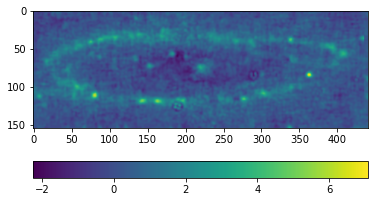

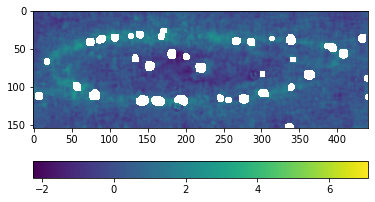

In [8]:
#th_min = th_mask
th_min = 0
th_max = np.pi
th_range_in = [th_min, th_max]
this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, rl=rl_mask)
ma_data= ma.array(data, mask=np.logical_not(this_mask))
minmin = np.min(data)
maxmax = np.max(data)
fig = plt.figure()
plt.imshow(data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/real_data.pdf')
fig = plt.figure()
plt.imshow(ma_data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/ps_center_masked_data.pdf')

initial values of the model params are:  [0.0e+00 1.0e+00 4.0e+00 1.5e-02 3.0e-03]
initial weights are: w0 = 0.0; w1 = 1.0; w2 = 4.0; w3 = 0.015; w4 = 0.003; 
chi^2 = 219548.9569884917
w_fin:  [-1.17403894e-01  1.10136712e+00  4.20851577e+00  1.41922167e-02
  3.61117234e-03]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final chi2: 192638.35486231832


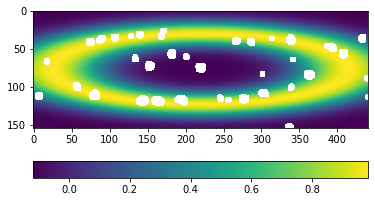

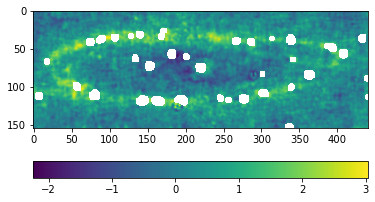

In [9]:
w_init = np.array([0,  1,  4,  0.015, 3e-3])
print('initial values of the model params are: ', w_init)
#plt.imshow(ma.array(f([AX_N, AX_n], w_init), mask=np.logical_not(this_mask)))

#print initial statistics
this_chi2 = chi2(w_init, *(data, [AX_N, AX_n],  noise, this_mask))
statement1 = 'initial weights are: '
for j in range(len(w_init)):
    statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))

# update weights
bnds = [(-1, 1), (0, 2), (3, 5), (.01 , 0.02), (1e-3, 1e-2)]
res = minimize(chi2, w_init, args=(data, [AX_N, AX_n], noise, this_mask), bounds=bnds)

w_fin = res.x
print('w_fin: ', w_fin)
print(res.success)
print(res.message)
chi2_final = chi2(w_fin, *(data, [AX_N, AX_n], noise, this_mask))
print('final chi2: '+ str(chi2_final)) 
fig = plt.figure()
new_model = f([AX_N, AX_n], w_fin)
plt.imshow(ma.array(new_model, mask=np.logical_not(this_mask))) 
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/best_ring_model_masked.pdf')
fig = plt.figure()
plt.imshow(ma_data)
plt.colorbar(orientation='horizontal')

In [10]:
mode = 'load'
starting_samples = tuple((0,0))
b_sim = tuple(('ring','noring'))
num_samples = 1000
ell_params = list(w_fin[1:])
#grab the mask thicknesses from cell 73 or 74 in compare_ringvnoring notebook
#mask_thicknesses = [0, 0.0033801168648913103, 0.007859198067988, 0.009002003858080398, 0.00918183948269248] (when using full immage)
#mask_thicknesses = [0, 0.0028699559142665583, 0.005224923993013385, 0.0059781383874197265, 0.00841756796806498] #when using left mask
mask_thicknesses = [0, .002, .004, .006, .008, .01]

In [11]:
#create masks
rl_mask = ''
mask_set=[]
for thickness in mask_thicknesses:
    this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, coords=(AX_N, AX_n), ellipse_params=[ell_params[1], ell_params[2], thickness], \
                        method='ellipse_and_azimuthally_sym', rl=rl_mask)
    mask_set.append(this_mask)
mask_set = np.array(mask_set)

#prepare sets of sigmav mx and D0
frac = 2.7
beam_cut = 5
sig_type = 2
sigmav_bench = 2.2e-26
mx_start = 6
mx_stop = 500
num_mx = 20
sigmav_start = -27
sigmav_end = -23
num_sigmav = 80
num_masks = len(mask_thicknesses)

#make these be  in increasing order
D0_set_in = np.array([3e29])
mx_set_in = np.round(np.logspace(np.log10(mx_start), np.log10(mx_stop), num_mx), 1)
sigmav_ar = np.logspace(sigmav_start, sigmav_end, num_sigmav)

In [81]:
#extract info of runs that match criteria
run_list = mt.find_results(sig_type, mx=mx_set_in, D0=D0_set_in)
num_runs = len(run_list)
print('length of run_list: ', str(num_runs))
signal_temp_set = []
mx_set_out = []
D0_set_out = []
for run in run_list:
    print(run)
    mx_set_out.append(run['mx'])
    D0_set_out.append(run['D0'])
    this_signal_temp, _ = gen_templates(run, nu_data, omega_beam, AX_N, AX_n)
    signal_temp_set.append(this_signal_temp)
mx_set_out = np.array(mx_set_out)
D0_set_out = np.array(D0_set_out)
signal_temp_set = np.array(signal_temp_set)

#sort runs
ind = sort_runs(mx_set_out, D0_set_out)
mx_set_out = mx_set_out[ind]
D0_set_out = D0_set_out[ind]
signal_temp_set = signal_temp_set[ind]
run_list = [run_list[i] for i in ind]

this_path = /het/p4/mjw283/eventgen_wd/Secondary_radiation/scripts/manipulate_text.py
length of run_list:  20
{'file_name': '0027_synchrotron_emission_info.txt', 'mx': 9.6, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1, 35.0], 'nu_range': [100000.0, 1e+24]}
{'file_name': '0031_synchrotron_emission_info.txt', 'mx': 15.2, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1, 35.0], 'nu_range': [100000.0, 1e+24]}
{'file_name': '0025_synchrotron_emission_info.txt', 'mx': 7.6, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1, 35.0], 'nu_range': [100000.0, 1e+24]}
{'file_name': '0023_synchrotron_emission_info.txt', 'mx': 6.0, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1,

To compute $\left.\Delta\chi^2\right|_{sb}$ and $\left.\Delta\chi^2\right|_{b}$ efficiently, I plan to use numpy slicing methods. For each simulated intensity map, $\Delta\chi^2$ depends on the masked pixels, $m_\chi$, and $\langle\sigma v\rangle$. For 5 masks, 20 values of $m_\chi$, and 80 values of $\langle \sigma v\rangle$,  $\Delta\chi^2$ will have $5\times 20\times 80 = 8000$ entries. Each entry in $\Delta \chi^2$ can naively be computed by taking the differnece of $\chi^2_{sb}-\chi^2_{b}$ which each requires a sum over the non masked pixels in the image. If this sum is computed for each of the $8000$ entries separately, then the algorithm will take a long time. If terms are collected and numpy.sum is used to sum over the pixels for each entry using a numpy loop, the algorithm will be much quicker, but there may be storage problems. Before this sum is executed, the array to be summed will have a shape of $(5, 20, 80, 155, 441)$ (assuming the same number of entries as earlier) which implies that there will be $5\times 20\times 80\times 155\times 441 \simeq 5.5 \times 10^8$. Arrays take up 8 bytes per entry which means that the array will take up $4.4 \rm{Gb}$. To work around this issue I will try to break down $\Delta \chi^2$ into individual terms which each takes the form of a sum over pixels with coefficients pulled out in front of the sum. This will make it so that the array to be partially summed will not need to have all of the indices that $\Delta \chi^2$ will have but numpy loops can still be used. Starting with the background only case, where the simulated intensity in pixel $i$ is given by $R_i$, we have
$$
\begin{split}
\left.\Delta \chi^2\right|_b &= \left. \chi^2_{sb}\right|_b-\left. \chi^2_{b}\right|_b \\
&=\sum_i\frac{(R_i-f_{sb,i}^{b}(\langle\sigma v\rangle))^2}{\sigma_i^2}-\sum_i\frac{(R_i-f_{b,i}^{b})^2}{\sigma_i^2}
\end{split}
$$
where $f_{sb,i}^{b}(\langle\sigma v\rangle)$ is the intensity in pixel $i$ of the signal plus background model with cross section $\langle \sigma v \rangle$ fit to the background only simulated intensity map and $f_{b,i}^{b}$is the intensity in pixel $i$ of the background-only model fit to the background only simulated intensity map. These can be written as
$$
\begin{split}
&f_{sb,i}^{b} = \frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}f_{s,i}(m_\chi) + w^{b}_{sb} f_{b,i}\\
&f_{b,i}^{b} = w^{b}_b f_{b,i}
\end{split}
$$
where $f_{s,i}(m_\chi)$ is the signal intensity in pixel $i$ for a dark matter mass of $m_\chi$ for a cross section given by the benchmark cross section, $\langle \sigma v \rangle_0$ and $f_{b_i}$ is the normalized background model inensity in pixel $i$ and in our case is $1$ for all $i$. The free parameters $w^{sb}_b$ and $w^b_b$ of each model are chosen to minimize each respective $\chi^2$ are given by
$$
\begin{split}
&w^{b}_b = \left[\sum_i\frac{f_{b,i}^2}{\sigma_i^2}\right]^{-1}\sum_i \frac{R_i f_{b,i}}{\sigma_i^2}\\
&w^{b}_{sb} = \left[\sum_i\frac{f_{b,i}^2}{\sigma_i^2}\right]^{-1} \sum_i \frac{\left[R_i-\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}f_{s,i}(m_\chi)\right]f_{b,i}}{\sigma_i^2} = w^{b}_b - \left[\sum_i\frac{f_{b,i}^2}{\sigma_i^2}\right]^{-1}\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\sum_i\frac{f_{s,i}(m_\chi)f_{b,i}}{\sigma_i^2}
\end{split}
$$

After some algebra, the equation for $\Delta \chi^2$ can be written as
$$
\left.\Delta\chi^2\right|_b = 2(w_b^b-w_{sb}^b)\sum_i\frac{R_i f_{b,i}}{\sigma_i^2}-2\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\sum_i\frac{R_i f_{s,i}}{\sigma_i^2}+\left(\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\right)^2\sum_i\frac{f_{s,i}^2}{\sigma_i^2}+({w_{sb}^b}^2-{w_{b}^b}^2)\sum_i\frac{f_{b,i}^2}{\sigma_i^2} +\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}w_{sb}^b\sum_i\frac{f_{b,i}f_{s,i}}{\sigma_i^2} 
$$

For $\left.\Delta \chi^2\right|_{sb}$, the following replacements should be made to the first equation

$$
\begin{split}
R_i &\rightarrow R_i + \frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}f_{s,i}(m_\chi)\\
f_{sb}^{b} &\rightarrow f_{sb}^{sb} = \frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}f_{s,i}(m_\chi) + w^{sb}_{sb} f_{b,i}\\
f_{b}^{b} &\rightarrow f_{b}^{sb} = w^{b}_{sb} f_{b,i}
\end{split}
$$

where

$$
\begin{split}
&w^{sb}_{sb} = \left[\sum_i\frac{f_{b,i}^2}{\sigma_i^2}\right]^{-1}\sum_i \frac{R_i f_{b,i}}{\sigma_i^2} = w^b_b\\
&w^{sb}_{b} = \left[\sum_i\frac{f_{b,i}^2}{\sigma_i^2}\right]^{-1} \sum_i \frac{\left[R_i+\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}f_{s,i}(m_\chi)\right]f_{b,i}}{\sigma_i^2} = w^{sb}_{sb} + \left[\sum_i\frac{f_{b,i}^2}{\sigma_i^2}\right]^{-1}\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\sum_i\frac{f_{s,i}(m_\chi)f_{b,i}}{\sigma_i^2}
\end{split}
$$

The result for $\left. \Delta \chi^2\right|_{sb}$ is 

$$
\left. \Delta \chi^2\right|_{sb} = 2(w_b^{sb}-w_{sb}^{sb})\sum_i\frac{R_i f_{b,i}}{\sigma_i^2}-2\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\sum_i\frac{R_i f_{s,i}}{\sigma_i^2} - \left(\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\right)^2\sum_i\frac{f_{s,i}^2}{\sigma_i^2} + ({w_{sb}^{sb}}^2-{w_{b}^{sb}}^2)\sum_i\frac{f_{b,i}^2}{\sigma_i^2}+\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}w_{b}^{sb}\sum_i\frac{f_{b,i}f_{s,i}}{\sigma_i^2} 
$$

In [82]:
#initialize arrays
dchi2_sb = [np.zeros((num_masks, num_runs, num_sigmav, num_samples+1)) for item in b_sim]
dchi2_b = [np.zeros((num_masks, num_runs, num_sigmav, num_samples+1)) for item in b_sim]

In [83]:
#compute quantities that do not need to be recalculated for each image
#isotropic background template
back_temp = np.ones((n,N))

#sums in dchi^2 that are independent of simulated intensity map
sum3 = np.einsum('ijk,ljk', mask_set, signal_temp_set**2/noise**2)
sum4 = np.sum(mask_set/(noise**2), axis=(1,2))
sum5 = np.einsum('ijk,ljk', mask_set, signal_temp_set/noise**2)

#how much should the uniform background change by if we add or subtract the signals
dw = (np.einsum('ljk,ijk', mask_set, signal_temp_set*back_temp/noise**2)/sum4).T
dw_sigmav = np.multiply.outer(dw, sigmav_ar/sigmav_bench)

#coefficients in dchi^2 that are independent of simulated intensity map. Signs on coefficeints
#are correct for dchi^2_b and some signs my need to change for dchi^2_sb
coef1 = 2*dw_sigmav #sum1
coef2 = -2*sigmav_ar/sigmav_bench #sum2
coef3 = (sigmav_ar/sigmav_bench)**2 #sum3; opposite sign for sb
coef5 = - dw_sigmav**2 #sum4; opposite sign for sb
coef7 = - dw_sigmav*sigmav_ar/sigmav_bench #sum5; opposite sign for sb

#terms in dchi^2 that are independent of simulated intensity map. Signs are correct for 
#dchi^2_b and signs need to be flipped  for dchi^2_sb where indicated
term3 = np.multiply.outer(sum3, coef3) #opposite sign for sb
term5 = (coef5.transpose((1, 2, 0))*sum4).transpose((2,0,1)) #opposite sign for sb
term7 = (coef7.transpose((2, 0, 1))*sum5).transpose((1, 2, 0)) #opposite_sign for sb

In [84]:
for i in range(num_samples+1):
    if i<num_samples:
        print('starting to generate sample number ' + str(i))
        #generate fake data residuals                                                                                                                                                       
        file_name_base = base_path + 'fake_resid_new/sigma_rms_'+ str(sigma_rms[0]) + '_' + \
                         str(sigma_rms[-1]) + '_spacing_' + '{:.2e}'.format(dlt_N/frac) + '_samplenum_'
        file_name=file_name_base+str(i+starting_samples[0]) + '.npy'
        if mode == 'save' or mode == 'none':
            data_resid, _, _ = gen_fake_data(beam_cut, frac, sigma_rms_vals, sigma_BW, N, n, dlt_N, dlt_n)
            if mode == 'save':
                np.save(file_name, data_resid)
            print('sample number '+ str(starting_samples[0]+i) + ' generated')
        elif mode == 'load':
            data_resid = np.load(file_name)
        else:
            print('value mode is not recognized')
        #add residuals to best fit ring model                                                                                                                                               
        w_sim = [0] + ell_params
        fake_bmaps = [data_resid  + f([AX_N, AX_n], w_sim) if b=='ring' else data_resid for b in b_sim]
    else:
        #on the last iteration, use real data
        fake_bmaps = [data for b in b_sim]

    this_wsb_sb = [np.sum(mask_set*bmap*back_temp/noise**2, axis=(1,2))/sum4 for bmap in fake_bmaps]

    sum1 = [np.sum(mask_set*bmap/noise**2, axis=(1,2)) for bmap in fake_bmaps]
    sum2 = [np.einsum('ijk,ljk', mask_set*bmap/(noise**2) , signal_temp_set) for bmap in fake_bmaps]

    coef4 = [2*(dw_sigmav.transpose((1, 2, 0))*w).transpose((2,0,1)) for w in this_wsb_sb] #sum4
    #(wait to assemble coef6 until combining it with sum5)

    term1 = [(coef1.transpose((1,2,0))*s).transpose((2,0,1)) for s in sum1]
    term2 = [np.multiply.outer(s, coef2) for s in sum2]
    term4 = [(c.transpose((1, 2, 0))*sum4).transpose((2,0,1)) for c in coef4]
    term6 = [np.multiply.outer(((sum5.T*w).T), sigmav_ar/sigmav_bench) for w in this_wsb_sb]

    this_dchi2_b = [t1+t2+term3+t4+term5+t6+term7 for t1,t2,t4,t6 in zip(term1, term2, term4, term6)]
    this_dchi2_sb = [t1+t2-term3+t4-term5+t6-term7 for t1,t2,t4,t6 in zip(term1, term2, term4, term6)]
    for ind in range(len(b_sim)):
        dchi2_b[ind][:, : , :, i] = this_dchi2_b[ind]
        dchi2_sb[ind][:, : , :, i] = this_dchi2_sb[ind]


starting to generate sample number 0
starting to generate sample number 1
starting to generate sample number 2
starting to generate sample number 3
starting to generate sample number 4
starting to generate sample number 5
starting to generate sample number 6
starting to generate sample number 7
starting to generate sample number 8
starting to generate sample number 9
starting to generate sample number 10
starting to generate sample number 11
starting to generate sample number 12
starting to generate sample number 13
starting to generate sample number 14
starting to generate sample number 15
starting to generate sample number 16
starting to generate sample number 17
starting to generate sample number 18
starting to generate sample number 19
starting to generate sample number 20
starting to generate sample number 21
starting to generate sample number 22
starting to generate sample number 23
starting to generate sample number 24
starting to generate sample number 25
starting to generate s

starting to generate sample number 217
starting to generate sample number 218
starting to generate sample number 219
starting to generate sample number 220
starting to generate sample number 221
starting to generate sample number 222
starting to generate sample number 223
starting to generate sample number 224
starting to generate sample number 225
starting to generate sample number 226
starting to generate sample number 227
starting to generate sample number 228
starting to generate sample number 229
starting to generate sample number 230
starting to generate sample number 231
starting to generate sample number 232
starting to generate sample number 233
starting to generate sample number 234
starting to generate sample number 235
starting to generate sample number 236
starting to generate sample number 237
starting to generate sample number 238
starting to generate sample number 239
starting to generate sample number 240
starting to generate sample number 241
starting to generate samp

starting to generate sample number 435
starting to generate sample number 436
starting to generate sample number 437
starting to generate sample number 438
starting to generate sample number 439
starting to generate sample number 440
starting to generate sample number 441
starting to generate sample number 442
starting to generate sample number 443
starting to generate sample number 444
starting to generate sample number 445
starting to generate sample number 446
starting to generate sample number 447
starting to generate sample number 448
starting to generate sample number 449
starting to generate sample number 450
starting to generate sample number 451
starting to generate sample number 452
starting to generate sample number 453
starting to generate sample number 454
starting to generate sample number 455
starting to generate sample number 456
starting to generate sample number 457
starting to generate sample number 458
starting to generate sample number 459
starting to generate samp

starting to generate sample number 651
starting to generate sample number 652
starting to generate sample number 653
starting to generate sample number 654
starting to generate sample number 655
starting to generate sample number 656
starting to generate sample number 657
starting to generate sample number 658
starting to generate sample number 659
starting to generate sample number 660
starting to generate sample number 661
starting to generate sample number 662
starting to generate sample number 663
starting to generate sample number 664
starting to generate sample number 665
starting to generate sample number 666
starting to generate sample number 667
starting to generate sample number 668
starting to generate sample number 669
starting to generate sample number 670
starting to generate sample number 671
starting to generate sample number 672
starting to generate sample number 673
starting to generate sample number 674
starting to generate sample number 675
starting to generate samp

starting to generate sample number 868
starting to generate sample number 869
starting to generate sample number 870
starting to generate sample number 871
starting to generate sample number 872
starting to generate sample number 873
starting to generate sample number 874
starting to generate sample number 875
starting to generate sample number 876
starting to generate sample number 877
starting to generate sample number 878
starting to generate sample number 879
starting to generate sample number 880
starting to generate sample number 881
starting to generate sample number 882
starting to generate sample number 883
starting to generate sample number 884
starting to generate sample number 885
starting to generate sample number 886
starting to generate sample number 887
starting to generate sample number 888
starting to generate sample number 889
starting to generate sample number 890
starting to generate sample number 891
starting to generate sample number 892
starting to generate samp

The relevant expressions to the cell above are
$$
    \left.\Delta\chi^2\right|_b = 2(w_b^b-w_{sb}^b)\sum_i\frac{R_i f_{b,i}}{\sigma_i^2}-2\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\sum_i\frac{R_i f_{s,i}}{\sigma_i^2}+\left(\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\right)^2\sum_i\frac{f_{s,i}^2}{\sigma_i^2}+({w_{sb}^b}^2-{w_{b}^b}^2)\sum_i\frac{f_{b,i}^2}{\sigma_i^2} +\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}w_{sb}^b\sum_i\frac{f_{b,i}f_{s,i}}{\sigma_i^2} 
$$

$$
\left. \Delta \chi^2\right|_{sb} = 2(w_b^{sb}-w_{sb}^{sb})\sum_i\frac{R_i f_{b,i}}{\sigma_i^2}-2\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\sum_i\frac{R_i f_{s,i}}{\sigma_i^2} - \left(\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}\right)^2\sum_i\frac{f_{s,i}^2}{\sigma_i^2} + ({w_{sb}^{sb}}^2-{w_{b}^{sb}}^2)\sum_i\frac{f_{b,i}^2}{\sigma_i^2}+\frac{\langle\sigma v\rangle}{\langle\sigma v\rangle_0}w_{b}^{sb}\sum_i\frac{f_{b,i}f_{s,i}}{\sigma_i^2} 
$$

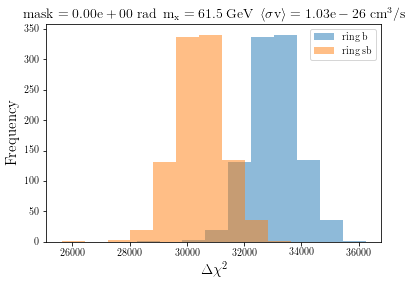

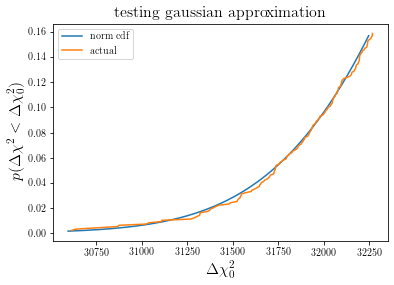

In [85]:
m=0
mchi = 10
sv = 20
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure()
plt.hist(dchi2_b[0][m, mchi, sv], label=b_sim[0]+' b', alpha=.5)
plt.hist(dchi2_sb[0][m, mchi, sv], label=b_sim[0]+' sb', alpha=.5)
plt.title(r'$\rm{mask} = '+r'{:.2e}'.format(mask_thicknesses[m])+ r'\;\rm{rad}\:\: m_x = '+ \
          str(mx_set_out[mchi])+ r'\;\rm{GeV}\:\: \langle\sigma v\rangle=' + r'{:.2e}'.format(sigmav_ar[sv])+ \
          r'\;\rm{cm^3/s}$', size = 14)
plt.xlabel(r'$\Delta \chi^2$', size=15)
plt.ylabel(r'Frequency', size=15)
plt.legend()
plt.savefig(base_path + 'stat_pipeline_results/sample_hist.pdf')

dchi2_b_mean = [np.mean(d[:,:,:,:-1], axis=-1) for d in dchi2_b]
dchi2_b_std = [np.std(d[:,:,:,:-1], axis=-1) for d in dchi2_b]
dchi2_sb_mean = [np.mean(d[:,:,:,:-1], axis=-1) for d in dchi2_sb]
dchi2_sb_std = [np.std(d[:,:,:,:-1], axis=-1) for d in dchi2_sb]
dchi2_data = dchi2_b[0][:,:,:,-1]

#test gaussian approx
this_dchi2_srt = np.sort(dchi2_b[0][m, mchi, sv, :-1])
this_dchi_mean = dchi2_b_mean[0][m, mchi, sv]
this_dchi_std = dchi2_b_std[0][m, mchi, sv]
p_ar = np.arange(1, len(this_dchi2_srt)+1)/len(this_dchi2_srt)
mini = np.min(this_dchi2_srt)
maxi = np.max(this_dchi2_srt)
z_range = 5
num_z = 1000
z = np.linspace(-z_range, z_range, num_z)
dchi_ar = this_dchi_std*z+this_dchi_mean
p_unit = norm.cdf(z)
minz = -3
maxz = -1
min_p = norm.sf(-minz)
max_p = norm.sf(-maxz)
min_ind1 = int(np.round(min_p*num_samples))
max_ind1 = int(np.round(max_p*num_samples))
min_ind2 = int(np.round(num_z*(minz+z_range)/(2*z_range)))
max_ind2 = int(np.round(num_z*(maxz+z_range)/(2*z_range))) 
fig = plt.figure()
plt.plot(dchi_ar[min_ind2:max_ind2], p_unit[min_ind2:max_ind2], label='norm cdf')
plt.plot(this_dchi2_srt[min_ind1:max_ind1], p_ar[min_ind1:max_ind1], label='actual')
plt.title(r'testing gaussian approximation', size=16)
plt.xlabel(r'$\Delta \chi^2_0$', size =16)
plt.ylabel(r'$p(\Delta\chi^2<\Delta\chi^2_0)$', size=16)
plt.legend()
plt.savefig(base_path+ 'stat_pipeline_results/check_gauss_approx.pdf')

In [86]:
#setup variables to check for agreement between gaussian cdf and real cdf
ch_bsim = 0
ch_ma = 0
ch_mx = [6, 8]
ch_dchib_srt = np.array([np.sort(dchi2_b[ch_bsim][ch_ma, ind, :, :-1]) for ind in ch_mx])
ch_dchisb_srt = np.array([np.sort(dchi2_sb[ch_bsim][ch_ma, ind, :, :-1]) for ind in ch_mx])
p = np.arange(1, ch_dchib_srt.shape[-1]+1)/ch_dchib_srt.shape[-1]
#interpolate dchi cdfs
interp_cdf_b = [[interpolate.interp1d(d_sv, p, kind='linear') for d_sv in d_mx] for d_mx in ch_dchib_srt]
interp_cdf_sb = [[interpolate.interp1d(d_sv, p, kind='linear') for d_sv in d_mx] for d_mx in ch_dchisb_srt]
#max and min values of ch_dchi
ch_dchib_min = ch_dchib_srt[:, :, 0] 
ch_dchib_max = ch_dchib_srt[:, :, -1]
ch_dchisb_min = ch_dchisb_srt[:, :, 0]
ch_dchisb_max = ch_dchisb_srt[:, :, -1]


In [87]:
z_range = 5
num_z = 1000
z = np.linspace(-z_range, z_range, num_z)
p_unit = norm.cdf(z)
dchi_b_arr = [np.multiply.outer(dstd, z)+np.multiply.outer(dmean, np.ones(num_z)) \
              for dstd, dmean in zip(dchi2_b_std, dchi2_b_mean)]
dchi_sb_arr = [np.multiply.outer(dstd, z)+np.multiply.outer(dmean, np.ones(num_z)) \
              for dstd, dmean in zip(dchi2_sb_std, dchi2_sb_mean)]
print('starting interpolation')
interp_funcs_b = [[[[interpolate.interp1d(darr_sigmav, p_unit, kind='cubic') for darr_sigmav in darr_mx] \
                    for darr_mx in darr_mask] for darr_mask in darr_bmap] for darr_bmap in dchi_b_arr]
interp_funcs_sb = [[[[interpolate.interp1d(darr_sigmav, p_unit, kind='cubic') for darr_sigmav in darr_mx] \
                    for darr_mx in darr_mask] for darr_mask in darr_bmap] for darr_bmap in dchi_sb_arr]
print('cdf of dchi2 distributions have been interpolated')

dchib_min = [dchi[:, :, :, 0] for dchi in dchi_b_arr]
dchib_max = [dchi[:, :, :, -1] for dchi in dchi_b_arr]
dchisb_min = [dchi[:, :, :, 0] for dchi in dchi_sb_arr]
dchisb_max = [dchi[:, :, :, -1] for dchi in dchi_sb_arr]

cl = 0.95
def CLs_min_alpha(dchi2, *args):
    #print(dchi2)
    alpha = 1-args[0]
    dbmin = args[1][0][0]
    dbmax = args[1][0][1]
    dsbmin = args[1][1][0]
    dsbmax = args[1][1][1]
    #print('sb min = ' , dsbmin, ' sb max = ', dsbmax, '  b_min = ', dbmin, '  b_max = ', dbmax)
    interp_b = args[2][0]
    interp_sb = args[2][1]
    if dchi2 < dbmin and dchi2 < dsbmin: #assume that CLb = 1 and so is CLsb
        res = 1
    elif dchi2 < dbmin and dchi2<dsbmax:
        #print('dchi^2 = ', dchi2, 'dchib_min = ', dbmin, 'dchib_max = ', dbmax, 'dchisb_min = ', dsbmin, 'dchisb_max = ', dsbmax)
        res = 1-interp_sb(dchi2)
    elif dchi2<dbmin and dchi2>dsbmax:
        res = 0
    elif dchi2 < dsbmin:
        res = 1/(1-interp_b(dchi2))
    elif dchi2 < dsbmax and dchi2<dbmax:
        res = (1-interp_sb(dchi2)) \
        /(1-interp_b(dchi2))
    elif dchi2<dbmax:
        res = 0
    elif dchi2<dsbmax:
        res = num_samples*(1-interp_sb(dchi2))
    elif dsbmax<=dbmax:
        res = 0
    else:
        res = num_samples
    return res-alpha


starting interpolation
cdf of dchi2 distributions have been interpolated


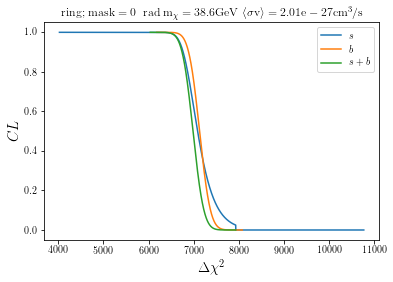

In [88]:
sim_i = 0
mask_i = 0
mx_i = 8
sig_i = 6
dchi_lims = [dchisb_min[sim_i][mask_i, mx_i, sig_i]-np.abs(dchisb_min[sim_i][mask_i, mx_i, sig_i])/3,\
             dchib_max[sim_i][mask_i, mx_i, sig_i]+np.abs(dchib_max[sim_i][mask_i, mx_i, sig_i])/3]
dchi_lims_b = [dchib_min[sim_i][mask_i, mx_i, sig_i], dchib_max[sim_i][mask_i, mx_i, sig_i]]
dchi_lims_sb = [dchisb_min[sim_i][mask_i, mx_i, sig_i], dchisb_max[sim_i][mask_i, mx_i, sig_i]]
dchi_arr_full = np.linspace(dchi_lims[0], dchi_lims[1], 5000)
dchi_arr_b = np.linspace(dchi_lims_b[0], dchi_lims_b[1], 5000)
dchi_arr_sb = np.linspace(dchi_lims_sb[0], dchi_lims_sb[1], 5000)
res = np.array([1-cl+CLs_min_alpha(d, *(cl, [[dchib_min[sim_i][mask_i, mx_i, sig_i], dchib_max[sim_i][mask_i, mx_i, sig_i]],\
                                                                          [dchisb_min[sim_i][mask_i, mx_i, sig_i], dchisb_max[sim_i][mask_i, mx_i, sig_i]]], \
                                                                    [interp_funcs_b[sim_i][mask_i][mx_i][sig_i], interp_funcs_sb[sim_i][mask_i][mx_i][sig_i]]))\
      for d in dchi_arr_full])
res_b = np.array([1-interp_funcs_b[sim_i][mask_i][mx_i][sig_i](d) for d in dchi_arr_b])
res_sb = np.array([1-interp_funcs_sb[sim_i][mask_i][mx_i][sig_i](d) for d in dchi_arr_sb])
fig= plt.figure()
plt.plot(dchi_arr_full, res, label=r'$s$')
plt.plot(dchi_arr_b, res_b, label=r'$b$')
plt.plot(dchi_arr_sb, res_sb, label=r'$s+b$')
plt.xlabel(r'$\Delta \chi^2$', size=15)
plt.ylabel(r'$CL$', size=15)
plt.title(b_sim[sim_i] + r';  $\rm{mask}='+str(mask_thicknesses[mask_i]) + r'\;\;\rm{rad}\; m_\chi = '+ str(mx_set_out[mx_i])+ \
                             r'\rm{GeV}\; \langle \sigma v\rangle = ' + '{:.2e}'.format(sigmav_ar[sig_i]) + r'\rm{cm^3/s}$')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')

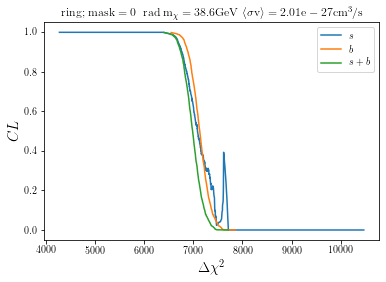

In [89]:
ch_ind_mx = np.where(np.array(ch_mx) == mx_i)[0][0]
dchi_lims_r = [ch_dchisb_min[ch_ind_mx , sig_i]-np.abs(ch_dchisb_min[ch_ind_mx, sig_i])/3,\
             ch_dchib_max[ch_ind_mx, sig_i]+np.abs(ch_dchib_max[ch_ind_mx, sig_i])/3]
dchi_lims_b_r = [ch_dchib_min[ch_ind_mx, sig_i], ch_dchib_max[ch_ind_mx, sig_i]]
dchi_lims_sb_r = [ch_dchisb_min[ch_ind_mx, sig_i], ch_dchisb_max[ch_ind_mx, sig_i]]
dchi_arr_full_r = np.linspace(dchi_lims_r[0], dchi_lims_r[1], 5000)
dchi_arr_b_r = np.linspace(dchi_lims_b_r[0], dchi_lims_b_r[1], 5000)
dchi_arr_sb_r = np.linspace(dchi_lims_sb_r[0], dchi_lims_sb_r[1], 5000)
res_r = np.array([1-cl+CLs_min_alpha(d, *(cl, [[ch_dchib_min[ch_ind_mx,sig_i],ch_dchib_max[ch_ind_mx,sig_i]],[ch_dchisb_min[ch_ind_mx,sig_i],ch_dchisb_max[ch_ind_mx,sig_i]]], \
                                        [interp_cdf_b[ch_ind_mx][sig_i], interp_cdf_sb[ch_ind_mx][sig_i]])) for d in dchi_arr_full_r])
res_b_r = np.array([1-interp_cdf_b[ch_ind_mx][sig_i](d) for d in dchi_arr_b_r])
res_sb_r = np.array([1-interp_cdf_sb[ch_ind_mx][sig_i](d) for d in dchi_arr_sb_r])
fig= plt.figure()
plt.plot(dchi_arr_full_r, res_r, label=r'$s$')
plt.plot(dchi_arr_b_r, res_b_r, label=r'$b$')
plt.plot(dchi_arr_sb_r, res_sb_r, label=r'$s+b$')
plt.xlabel(r'$\Delta \chi^2$', size=15)
plt.ylabel(r'$CL$', size=15)
plt.title(b_sim[sim_i] + r';  $\rm{mask}='+str(mask_thicknesses[mask_i]) + r'\;\;\rm{rad}\; m_\chi = '+ str(mx_set_out[mx_i])+ \
                             r'\rm{GeV}\; \langle \sigma v\rangle = ' + '{:.2e}'.format(sigmav_ar[sig_i]) + r'\rm{cm^3/s}$')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')

In [56]:
num=20
d_test = np.linspace(-1500, 1500, num)
test = [CLs_min_alpha(d, *((0,4,10,20), cl)) for d in d_test]   
print('test result: ' , test)

TypeError: unsupported operand type(s) for -: 'int' and 'tuple'

In [90]:
ind_guess = np.where(np.abs(p_unit-cl) == np.min(np.abs(p_unit-cl)))[0][0]
guesses = [d[:, :, :, ind_guess] for d in dchi_sb_arr]
dchi_solutions = [[[[fsolve(CLs_min_alpha, guesses[i][j,k,l], args=(cl, [[dchib_min[i][j,k,l], dchib_max[i][j,k,l]],\
                                                                          [dchisb_min[i][j,k,l], dchisb_max[i][j,k,l]]], \
                                                                    [interp_funcs_b[i][j][k][l], interp_funcs_sb[i][j][k][l]]))[0] \
                     if dchi2_b_mean[i][j,k,l] > dchi2_sb_mean[i][j,k,l] else dchisb_max[i][j,k,l] for l in range(num_sigmav)] \
                    for k in range(num_mx)] for j in range(num_masks)] for i in range(len(b_sim))]
CLb_heatmap = [[[[1-interp_funcs_b[i][j][k][l](dchi_solutions[i][j][k][l]) \
                  if dchi_solutions[i][j][k][l]<dchib_max[i][j][k][l] and dchi_solutions[i][j][k][l]>dchib_min[i][j][k][l] \
                  else 1 if dchi_solutions[i][j][k][l]<dchib_min[i][j][k][l] else 0 for l in range(num_sigmav)] \
                  for k in range(num_mx)] for j in range(num_masks)] for i in range(len(b_sim))]

CLb_heatmap_arr = [np.array([np.array([np.array(item_1d) for item_1d in item_2d]) for item_2d in item_3d]) for item_3d in CLb_heatmap]

/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


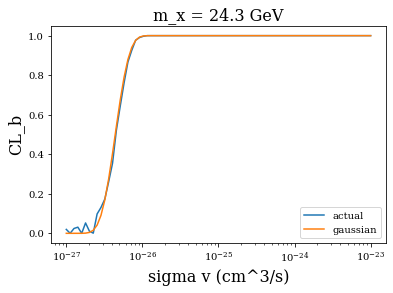

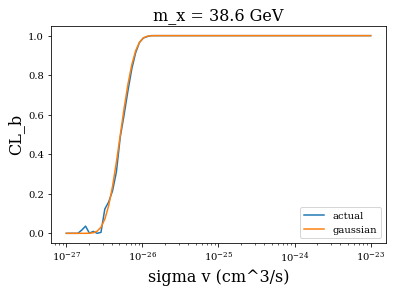

In [91]:
guesses = ch_dchisb_srt[:, :, np.where(np.abs(p-cl) == np.min(np.abs(p-cl)))[0][0]]
ch_dchi_sol = [[fsolve(CLs_min_alpha, guesses[i,j], args=(cl, [[ch_dchib_min[i,j],ch_dchib_max[i,j]],\
                                                             [ch_dchisb_min[i,j],ch_dchisb_max[i,j]]], \
                                                       [interp_cdf_b[i][j], interp_cdf_sb[i][j]]))[0] \
                for j in range(num_sigmav)] for i in range(len(ch_mx))]
CLb_heatmap_check = [np.array([1-interp_cdf_b[i][j](ch_dchi_sol[i][j]) \
                  if ch_dchi_sol[i][j]<ch_dchib_max[i, j] and ch_dchi_sol[i][j]>ch_dchib_min[i,j] \
                  else 1 if ch_dchi_sol[i][j]<ch_dchib_min[i, j] else 0 for j in range(num_sigmav)]) \
                  for i in range(len(ch_mx))]
plt.rc('text', usetex=False)
for i in range(len(ch_mx)):
    fig=plt.figure()
    plt.plot(sigmav_ar, CLb_heatmap_check[i], label='actual')
    plt.plot(sigmav_ar, CLb_heatmap_arr[0][0,ch_mx[i]], label='gaussian')
    plt.title('m_x = '+str(mx_set_out[ch_mx[i]])+' GeV', size = 16)
    plt.xlabel('sigma v (cm^3/s)', size = 16)
    plt.ylabel('CL_b', size=16)
    plt.legend()
    plt.xscale('log')

In [92]:
#get CLs distribuion based off of dchi from real data
CLs_min_alpha_real = [[[np.array([CLs_min_alpha(dchi2_data[j,k,l], *(cl, [[dchib_min[i][j,k,l], dchib_max[i][j,k,l]],\
                                                                          [dchisb_min[i][j,k,l], dchisb_max[i][j,k,l]]], \
                                                                    [interp_funcs_b[i][j][k][l], interp_funcs_sb[i][j][k][l]])) \
                                  for l in range(num_sigmav)]) for k in range(num_mx)] \
                       for j in range(num_masks)] for i in range(len(b_sim))]
print('CLs - alpha computed for various input')

#interpolate CLs-alpha vs sigmav for the various scenarios
CLs_real_interp = [[[interpolate.interp1d(sigmav_ar, CLs_real_mx, kind='cubic') \
                     for CLs_real_mx in CLs_real_mask] for CLs_real_mask in CLs_real] \
                   for CLs_real in CLs_min_alpha_real]
print('CLs-alpha interpolated with respect to sigmav for various mx, mask and background simulation methods')
sigmav_real_guess = [[[sigmav_ar[np.where(np.min(np.abs(CLs_mx))==np.abs(CLs_mx))[0][0]] \
                       for CLs_mx in CLs_mask] for CLs_mask in CLs_rvn] for CLs_rvn in CLs_min_alpha_real]
print('guesses of sigmav limits computed')
sigmav_lim_real = [[np.array([fsolve(CLs_real_interp[i][j][k], sigmav_real_guess[i][j][k])[0] \
                              if (not sigmav_real_guess[i][j][k] == 10**sigmav_start) and (not sigmav_real_guess[i][j][k] == 10**sigmav_end) \
                              else sigmav_real_guess[i][j][k] for k in range(num_mx)]) \
                    for j in range(num_masks)] for i in range(len(b_sim))]
print('sigmav limits computed')

CLs - alpha computed for various input
CLs-alpha interpolated with respect to sigmav for various mx, mask and background simulation methods
guesses of sigmav limits computed
sigmav limits computed


In [93]:
interp_heatmap = [[[interpolate.interp1d(sigmav_ar, heatmap_mx, kind='cubic') for heatmap_mx in heatmap_mask] for heatmap_mask in heatmap] for heatmap in CLb_heatmap]
print('CLb heatmaps have been interpolated')
num_z = 5
z_scores = np.linspace(-int((num_z-1)/2), int((num_z-1)/2), num_z)
CLb_vals = norm.cdf(z_scores)
def heatmap_min_CLb(sigmav, *args):
    CLb_val = args[0]
    inds = args[1]
    res = interp_heatmap[inds[0]][inds[1]][inds[2]](sigmav) - CLb_val
    return res

ind_guesses = [np.array([np.array([np.array([np.where(np.abs(heatmap_mx-CLb_val) == np.min(np.abs(heatmap_mx-CLb_val)))[0][0] \
                  for CLb_val in CLb_vals]) for heatmap_mx in heatmap_mask]) for heatmap_mask in heatmap]) for heatmap in CLb_heatmap]
print('indices of guess have been selected')
guesses = [sigmav_ar[tuple((ind_guess.reshape(num_masks*num_mx*num_z),))].reshape((num_masks,num_mx,num_z)) \
           for ind_guess in ind_guesses]
print('guesses have been chosen')
sigmav_lims = [[np.array([np.array([fsolve(heatmap_min_CLb, guesses[i][j,k,l], args=(CLb_vals[l], (i,j,k)))[0] for l in range(len(CLb_vals))]) \
               for k in range(num_mx)]) for j in range(num_masks)] for i in range(len(b_sim))]
print('lims have been solved for')

CLb heatmaps have been interpolated
indices of guess have been selected
guesses have been chosen
lims have been solved for


/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


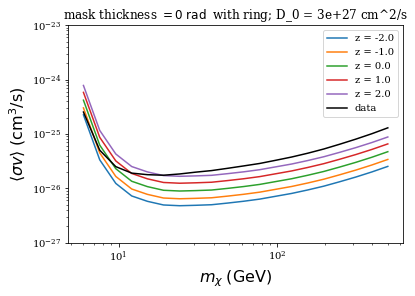

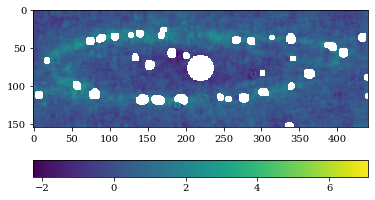

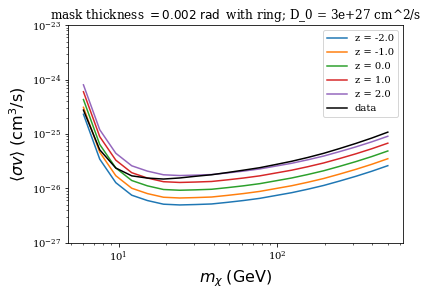

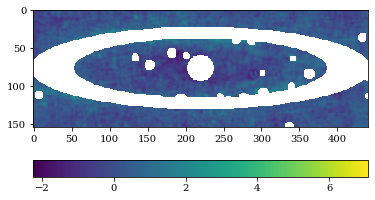

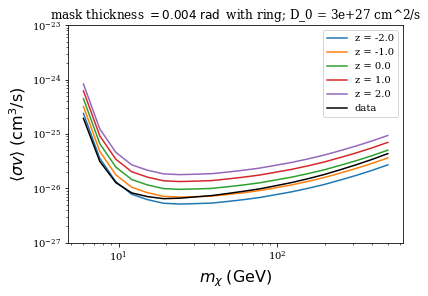

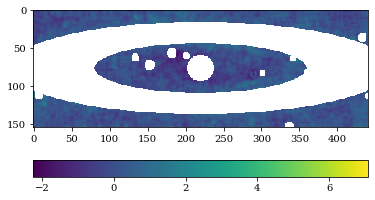

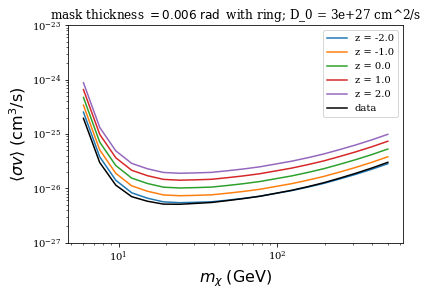

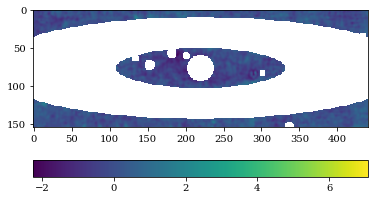

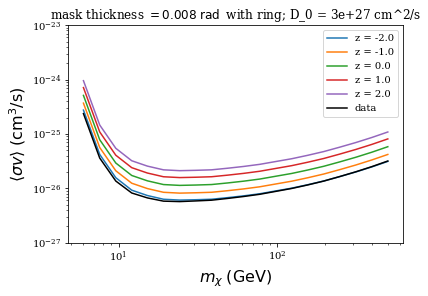

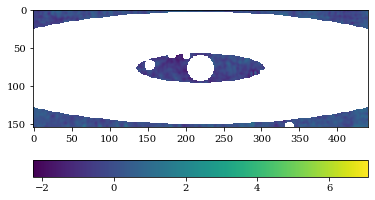

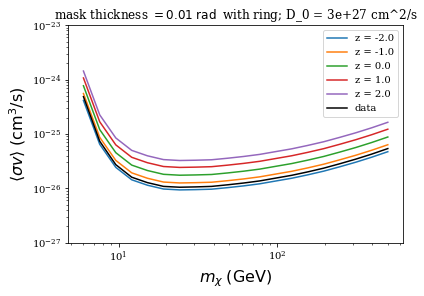

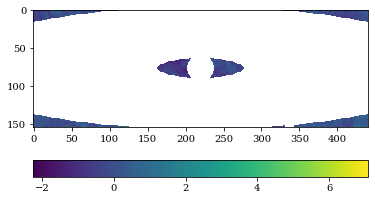

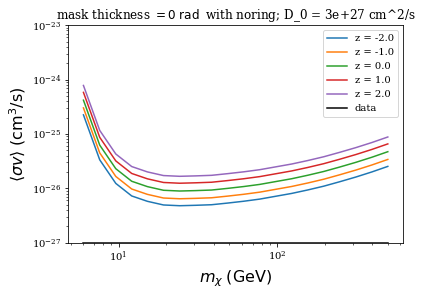

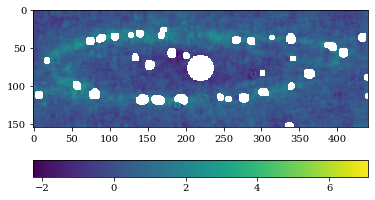

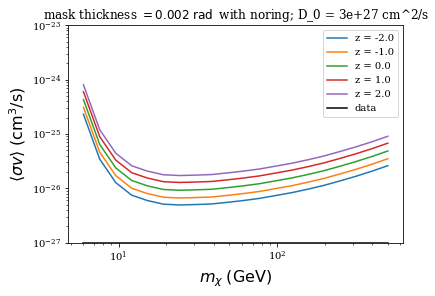

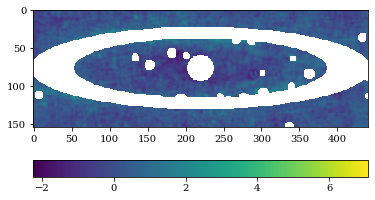

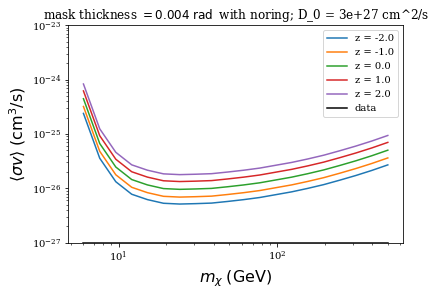

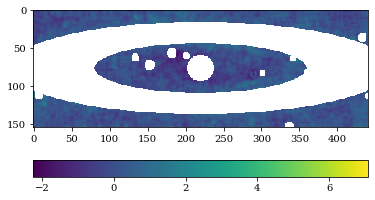

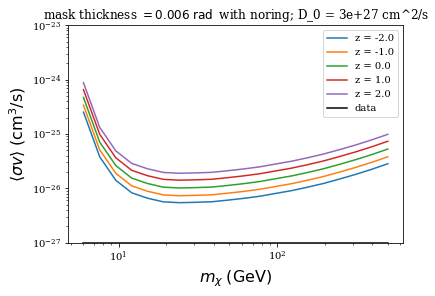

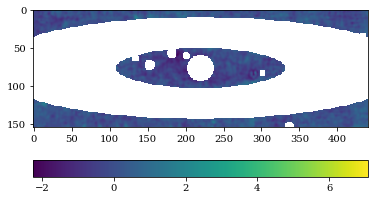

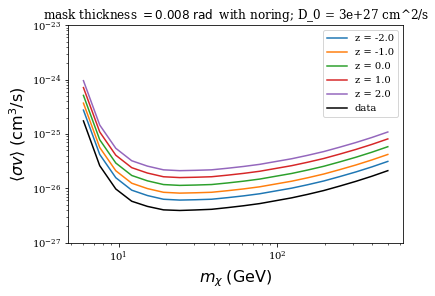

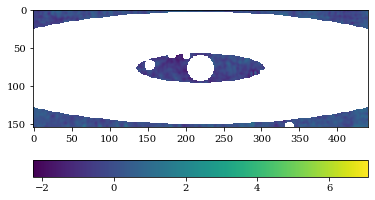

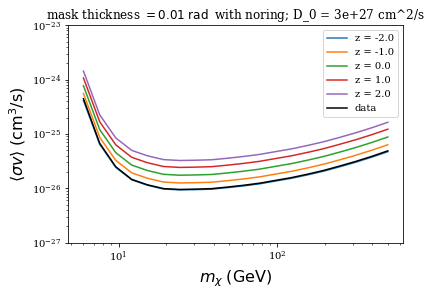

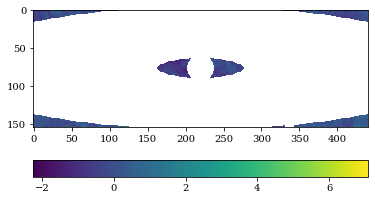

In [30]:
#use this one for D0 = 3e27 cm^2/s
for sigmav_limr, sigmav_lim, b in zip(sigmav_lim_real, sigmav_lims, b_sim):
    for sigmavlimr_mask, sigmavlim_mask, thickness, this_mask in zip(sigmav_limr, sigmav_lim, mask_thicknesses, mask_set):
        fig=plt.figure()
        for i in range(num_z):
            plt.plot(mx_set_out, sigmavlim_mask[:,i], label='z = '+str(z_scores[i]))
        plt.plot(mx_set_out, sigmavlimr_mask, label='data', color='k')
        ax = plt.gca()
        ax.set_ylim([10**(-27), 10**(-23)])
        plt.title(r'mask thickness $= '+ str(np.round(thickness, 4)) + r'\;\rm{rad} \;\;$' + r'with '+b + r'; D_0 = '\
                  + str(D0_set_out[0]) + ' cm^2/s')
        plt.ylabel(r'$\langle \sigma v\rangle \;\rm{(cm^3/s)}$', size=16)
        plt.xlabel(r'$m_\chi \;\rm{(GeV)}$', size=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        fig = plt.figure()
        plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax=np.max(data))
        plt.colorbar(orientation='horizontal')

/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


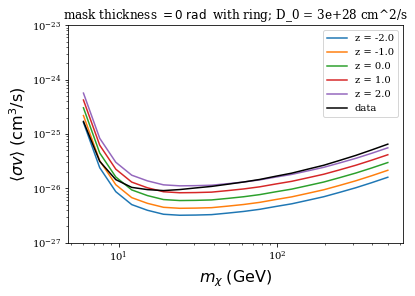

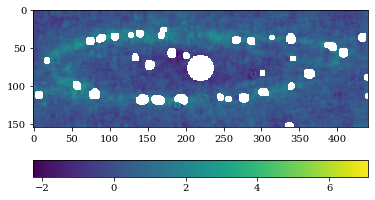

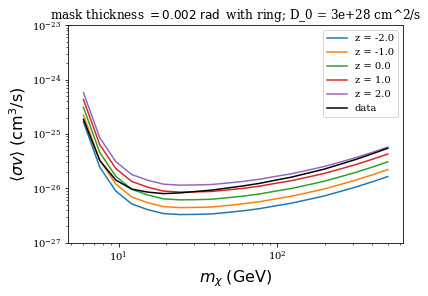

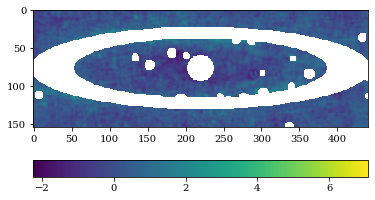

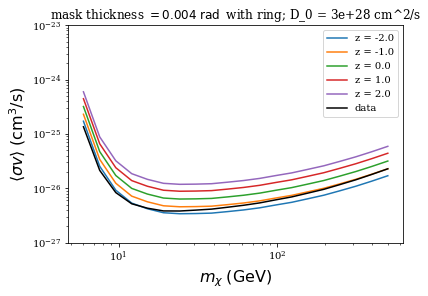

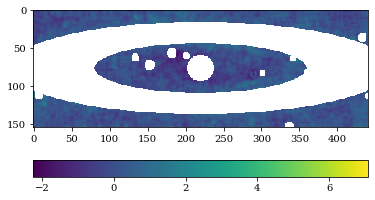

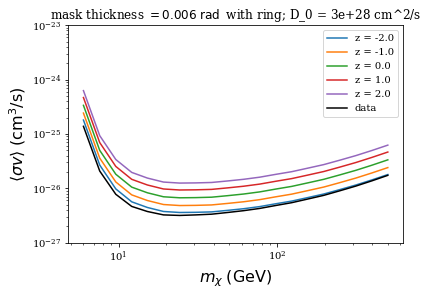

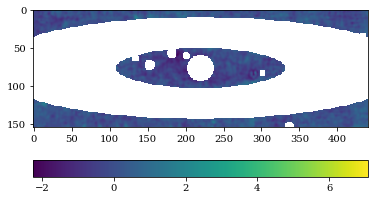

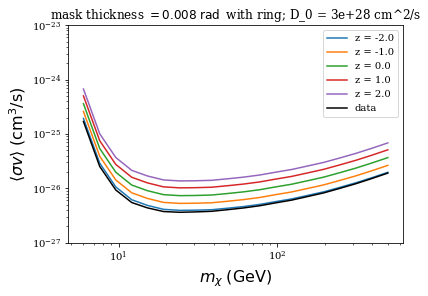

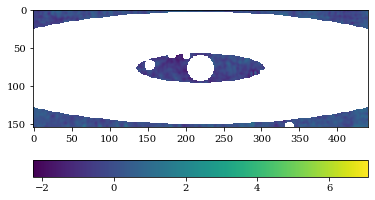

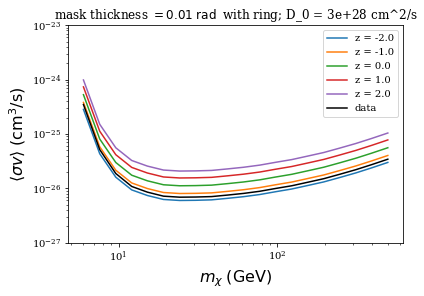

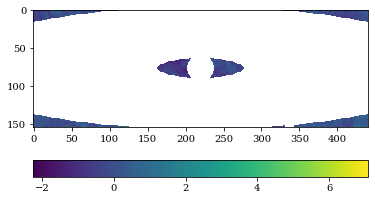

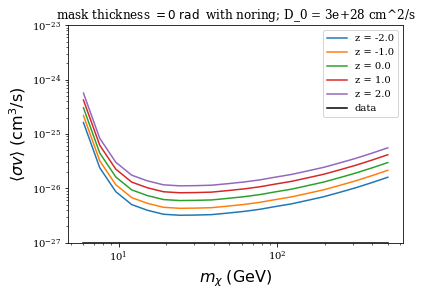

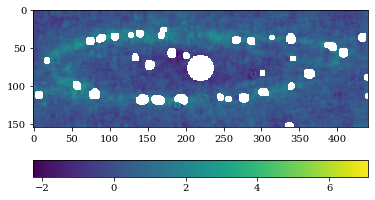

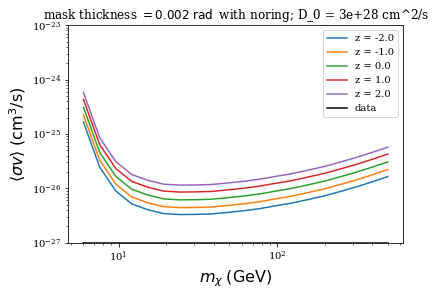

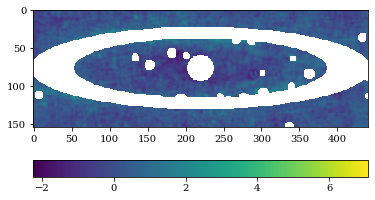

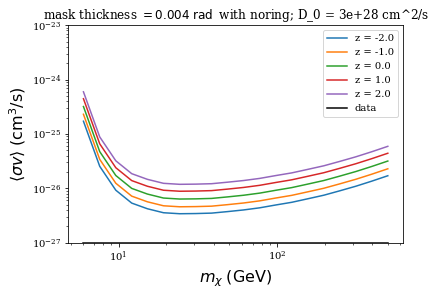

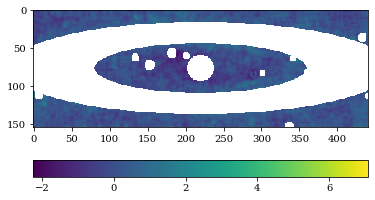

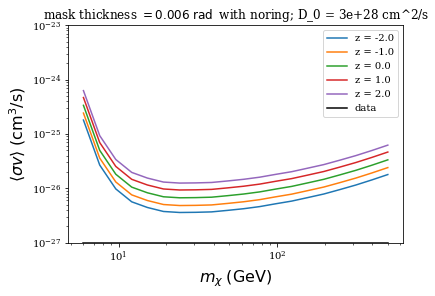

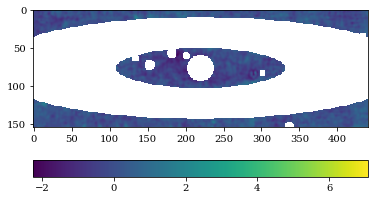

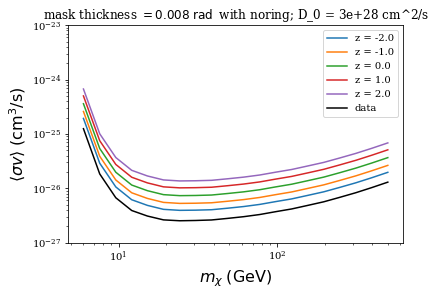

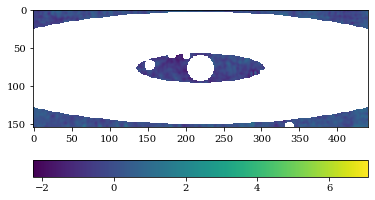

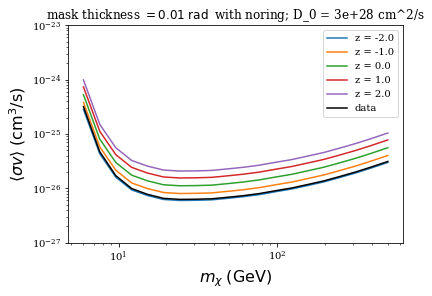

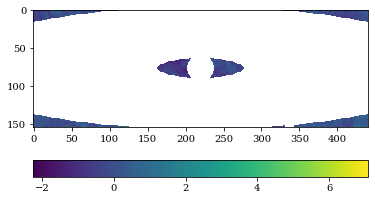

In [45]:
#use this one for D0 = 3e28 cm^/s
for sigmav_limr, sigmav_lim, b in zip(sigmav_lim_real, sigmav_lims, b_sim):
    for sigmavlimr_mask, sigmavlim_mask, thickness, this_mask in zip(sigmav_limr, sigmav_lim, mask_thicknesses, mask_set):
        fig=plt.figure()
        for i in range(num_z):
            plt.plot(mx_set_out, sigmavlim_mask[:,i], label='z = '+str(z_scores[i]))
        plt.plot(mx_set_out, sigmavlimr_mask, label='data', color='k')
        ax = plt.gca()
        ax.set_ylim([10**(-27), 10**(-23)])
        plt.title(r'mask thickness $= '+ str(np.round(thickness, 4)) + r'\;\rm{rad} \;\;$' + r'with '+b+ r'; D_0 = '\
                  + str(D0_set_out[0]) + ' cm^2/s')
        plt.ylabel(r'$\langle \sigma v\rangle \;\rm{(cm^3/s)}$', size=16)
        plt.xlabel(r'$m_\chi \;\rm{(GeV)}$', size=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        fig = plt.figure()
        plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax=np.max(data))
        plt.colorbar(orientation='horizontal')

/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


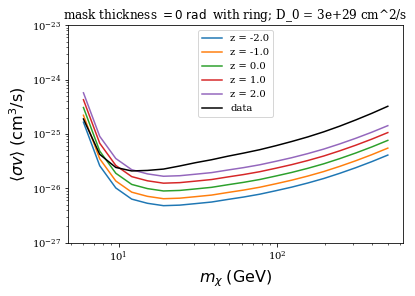

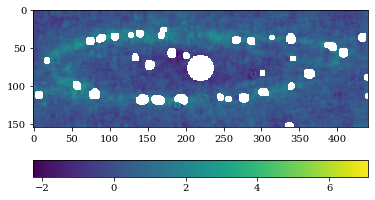

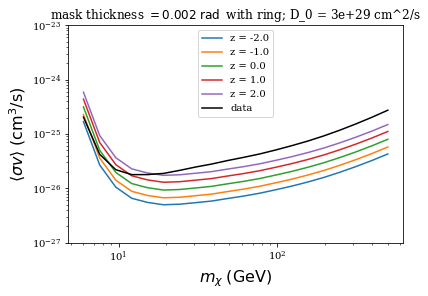

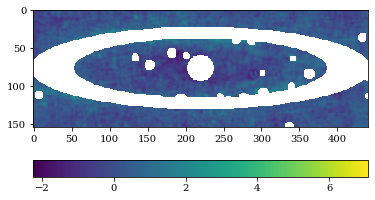

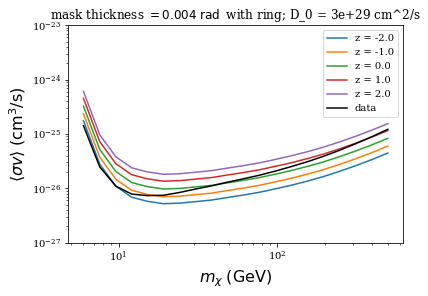

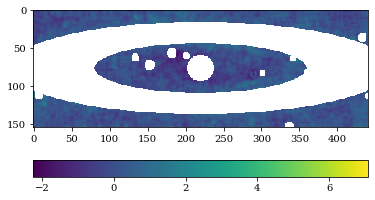

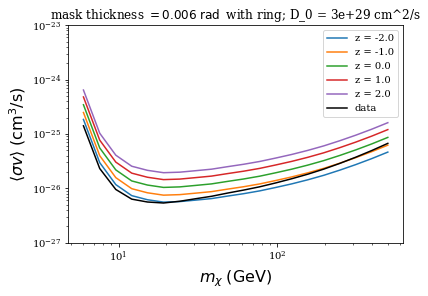

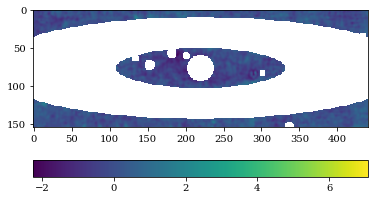

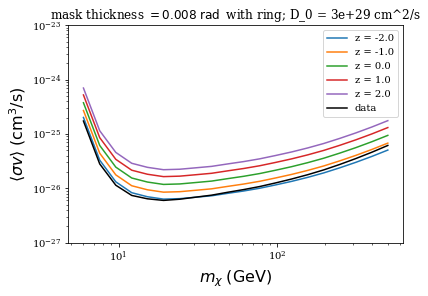

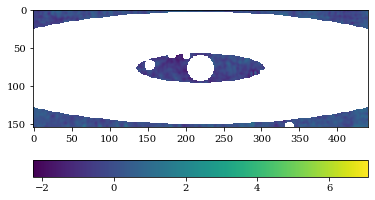

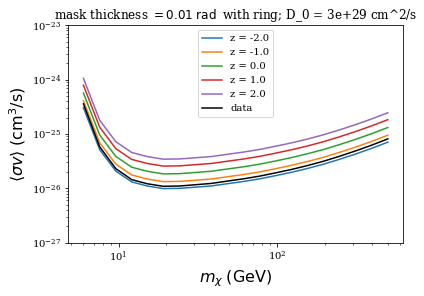

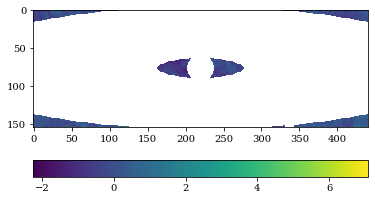

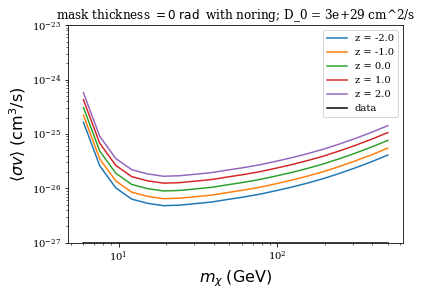

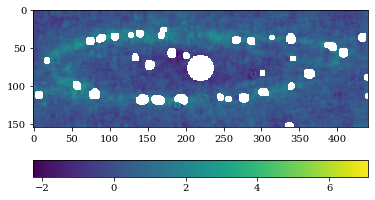

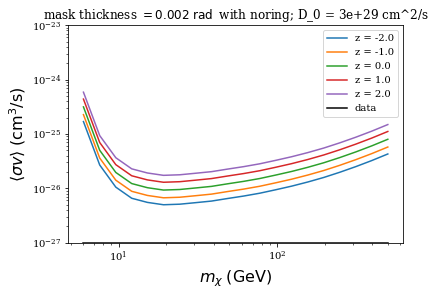

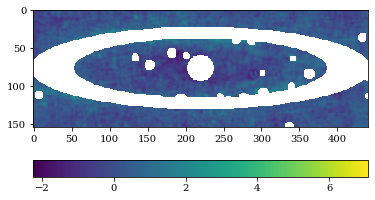

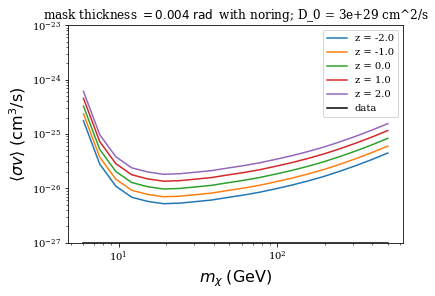

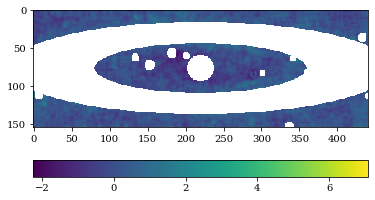

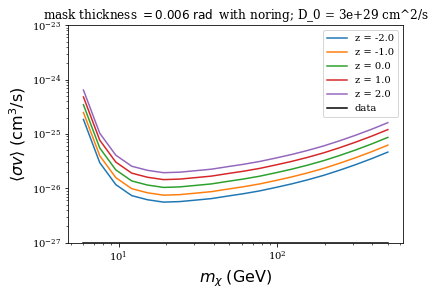

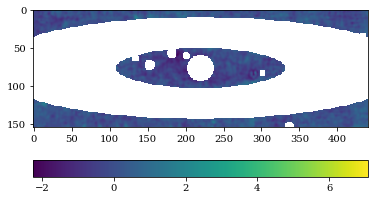

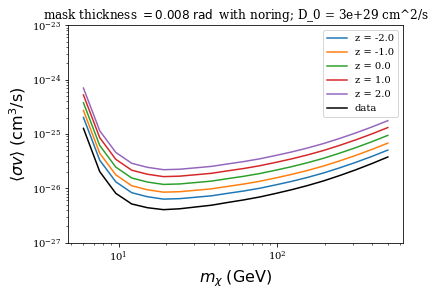

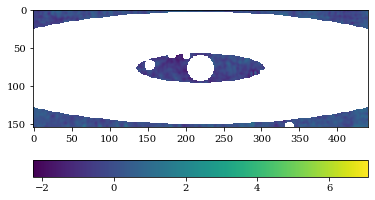

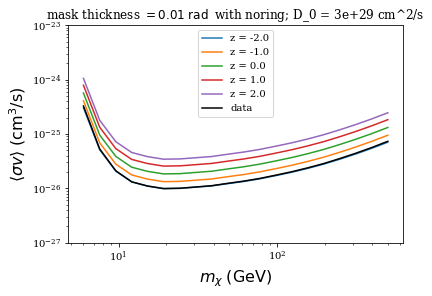

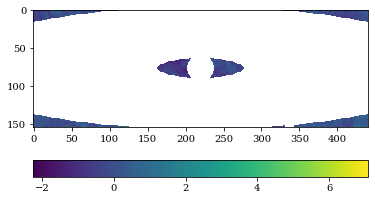

In [61]:
#use this one for D0 = 3e29 cm^2/s
for sigmav_limr, sigmav_lim, b in zip(sigmav_lim_real, sigmav_lims, b_sim):
    for sigmavlimr_mask, sigmavlim_mask, thickness, this_mask in zip(sigmav_limr, sigmav_lim, mask_thicknesses, mask_set):
        fig=plt.figure()
        for i in range(num_z):
            plt.plot(mx_set_out, sigmavlim_mask[:,i], label='z = '+str(z_scores[i]))
        plt.plot(mx_set_out, sigmavlimr_mask, label='data', color='k')
        ax = plt.gca()
        ax.set_ylim([10**(-27), 10**(-23)])
        plt.title(r'mask thickness $= '+ str(np.round(thickness, 4)) + r'\;\rm{rad} \;\;$' + r'with '+b + r'; D_0 = '\
                  + str(D0_set_out[0]) + ' cm^2/s')
        plt.ylabel(r'$\langle \sigma v\rangle \;\rm{(cm^3/s)}$', size=16)
        plt.xlabel(r'$m_\chi \;\rm{(GeV)}$', size=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        fig = plt.figure()
        plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax=np.max(data))
        plt.colorbar(orientation='horizontal')

/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


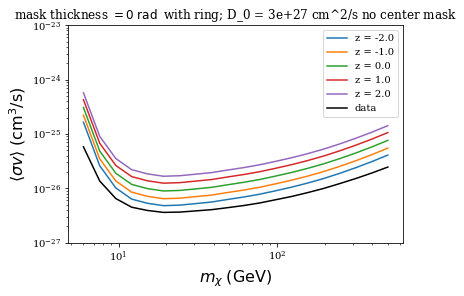

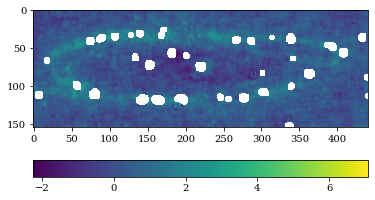

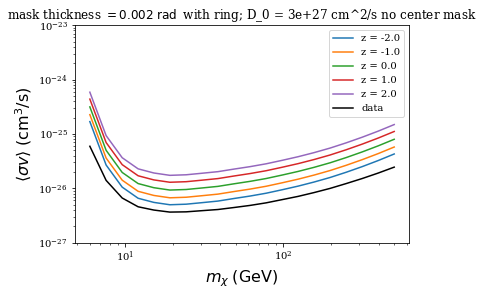

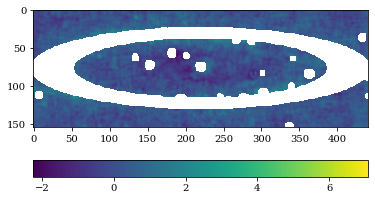

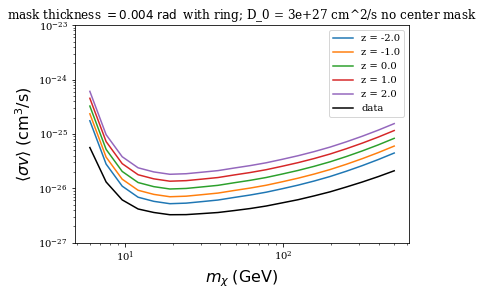

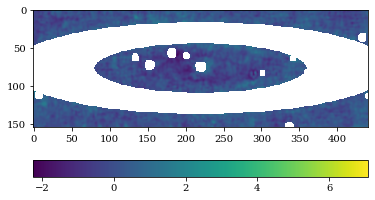

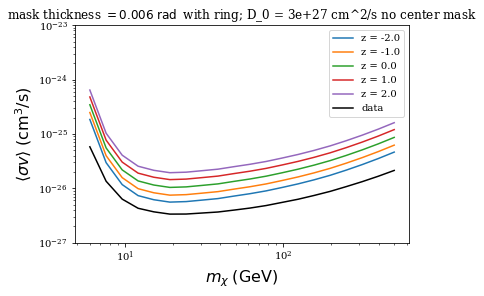

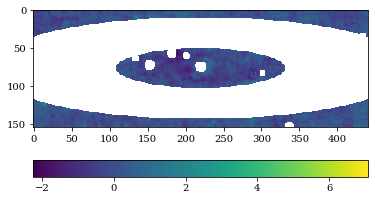

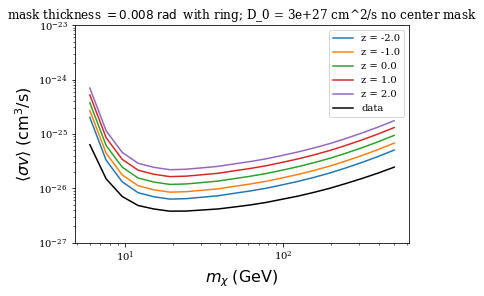

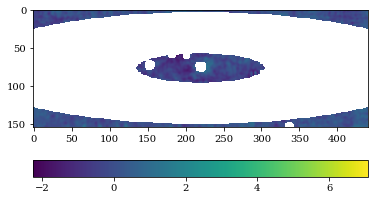

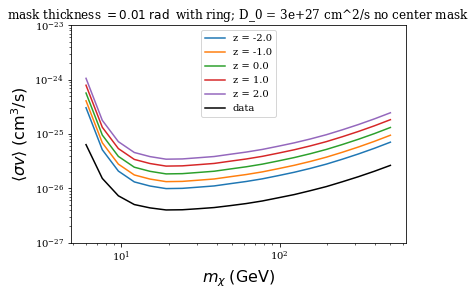

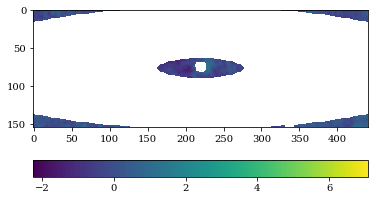

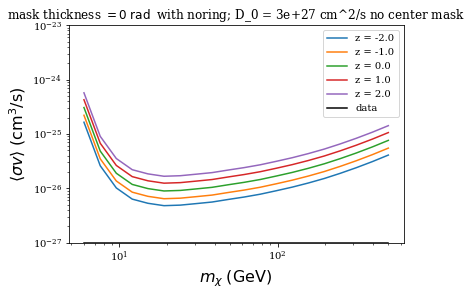

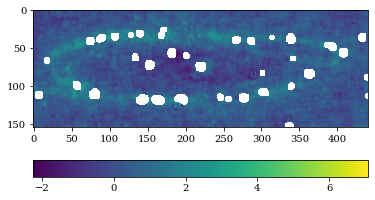

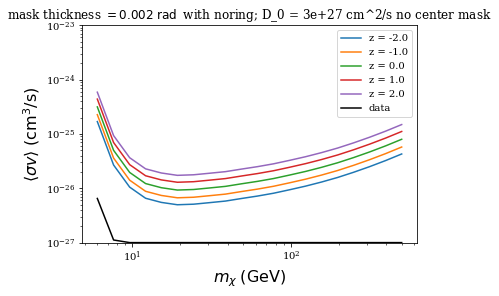

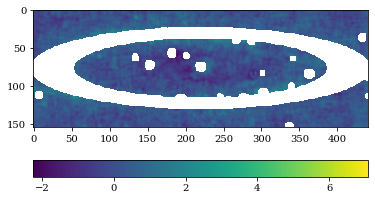

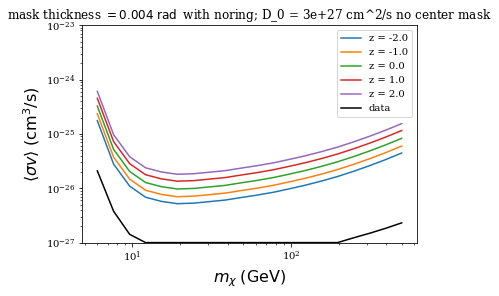

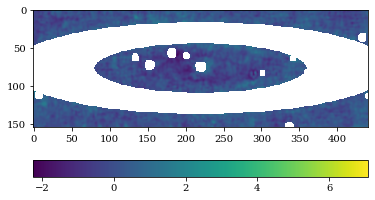

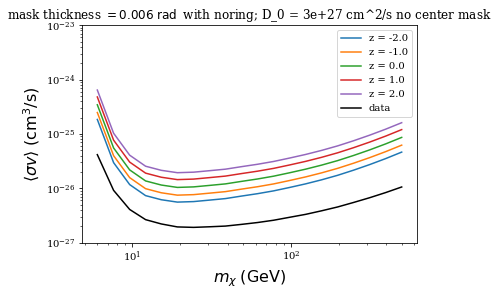

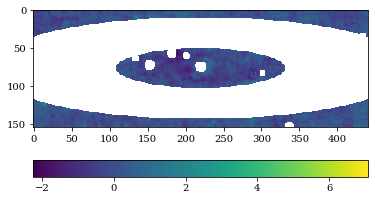

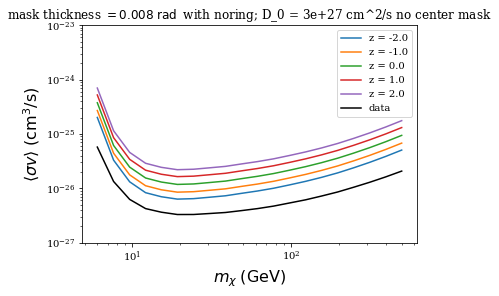

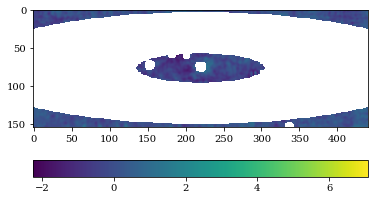

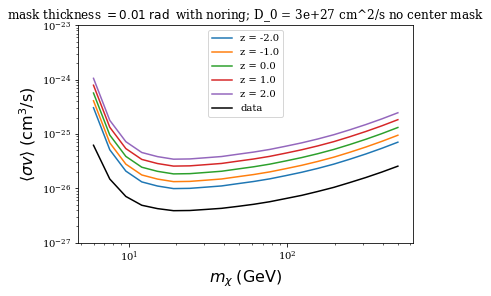

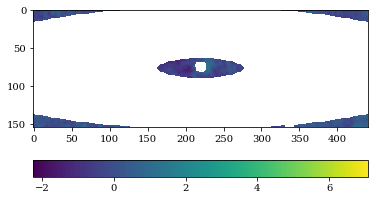

In [79]:
#use this one for D0 = 3e27 no center mask
for sigmav_limr, sigmav_lim, b in zip(sigmav_lim_real, sigmav_lims, b_sim):
    for sigmavlimr_mask, sigmavlim_mask, thickness, this_mask in zip(sigmav_limr, sigmav_lim, mask_thicknesses, mask_set):
        fig=plt.figure()
        for i in range(num_z):
            plt.plot(mx_set_out, sigmavlim_mask[:,i], label='z = '+str(z_scores[i]))
        plt.plot(mx_set_out, sigmavlimr_mask, label='data', color='k')
        ax = plt.gca()
        ax.set_ylim([10**(-27), 10**(-23)])
        plt.title(r'mask thickness $= '+ str(np.round(thickness, 4)) + r'\;\rm{rad} \;\;$' + r'with '+b+ r'; D_0 = '\
                  + str(D0_set_out[0]) + ' cm^2/s' + ' no center mask')
        plt.ylabel(r'$\langle \sigma v\rangle \;\rm{(cm^3/s)}$', size=16)
        plt.xlabel(r'$m_\chi \;\rm{(GeV)}$', size=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        fig = plt.figure()
        plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax=np.max(data))
        plt.colorbar(orientation='horizontal')

When I determine the ellipse mask and ellipse model from the whole image and then mask the left for the rest of the analysis, I find weaker limits than expected for no elliptical mask and the limits get stronger as the elliptical mask gets larger until mask thickness of ~0.09 rad when the limits get weaker again finishing between the $\pm 1 \sigma$ expected limits. The expected limits get weaker as the mask gets larger as expected. This can all be seen in the cell above.

When I perform the proceedure but mask the right side of the image, I find stronger limits than expected with no elliptical mask and the limits get weaker and then a little bit stronger and then a little bit weaker from 0 rad to 0.01 rad. The limits finish near the lower $2\sigma$ line. This can be seen below.

/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


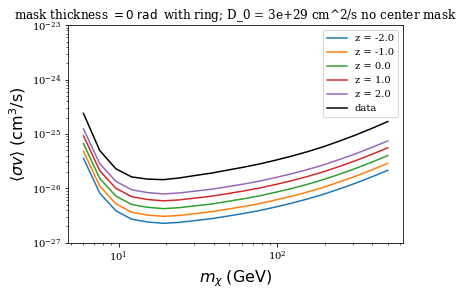

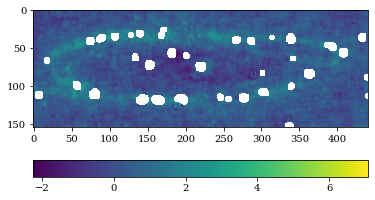

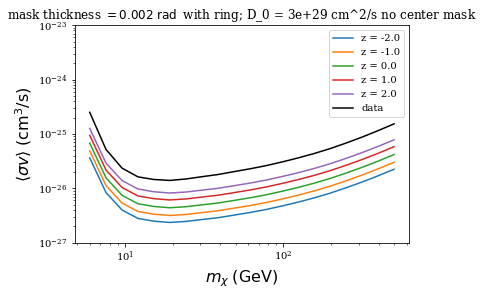

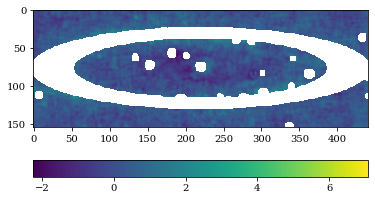

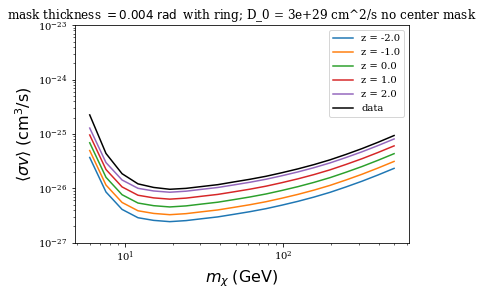

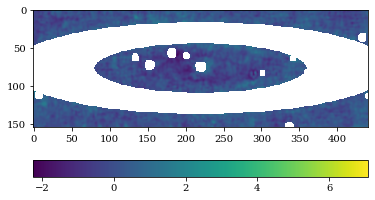

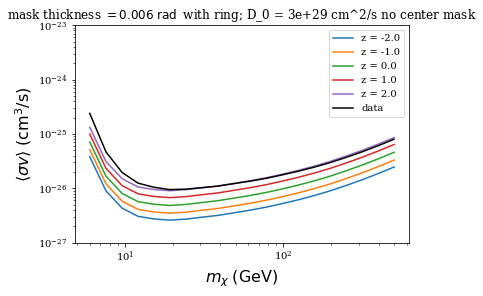

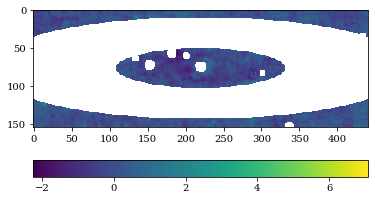

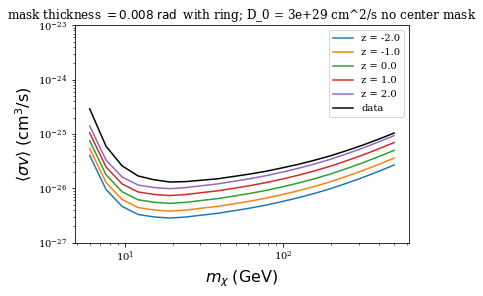

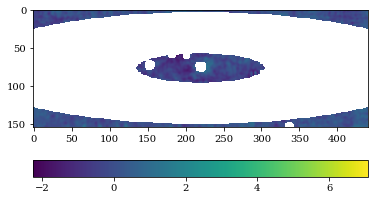

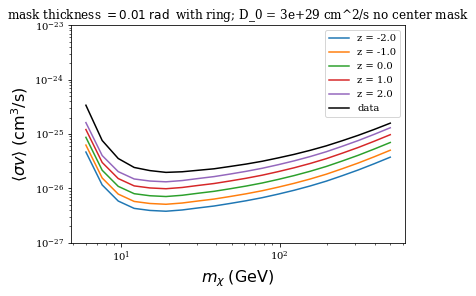

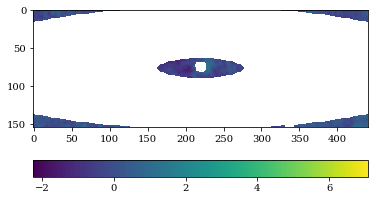

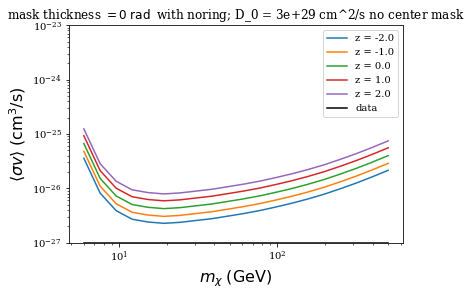

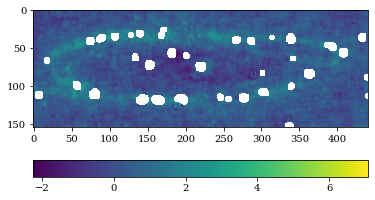

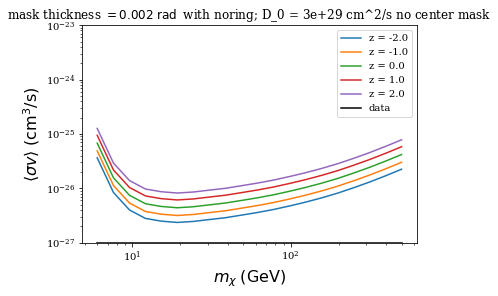

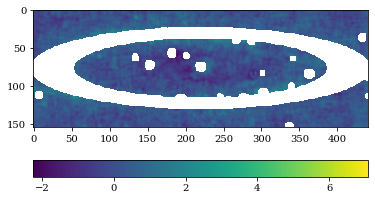

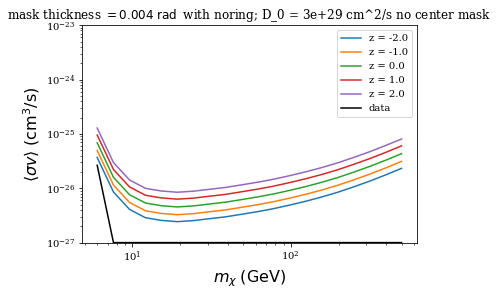

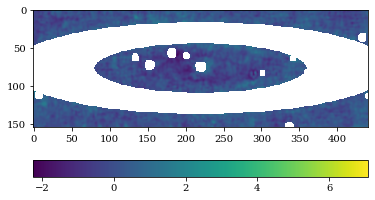

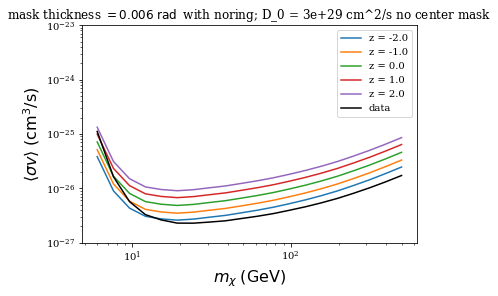

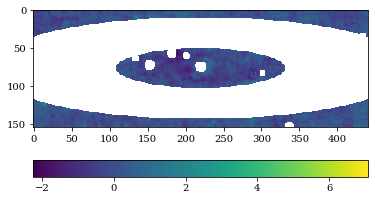

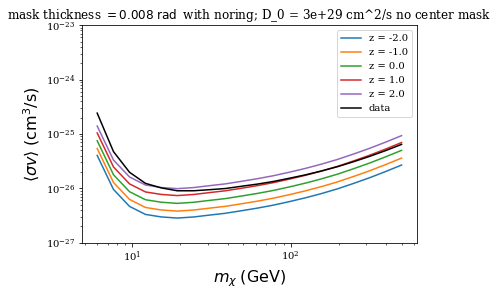

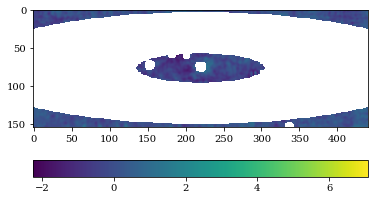

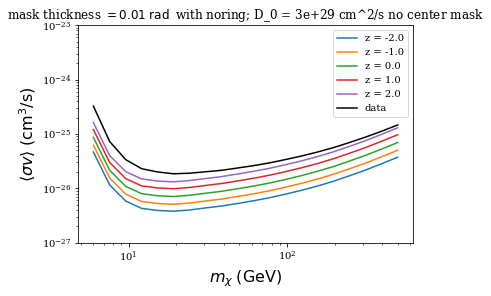

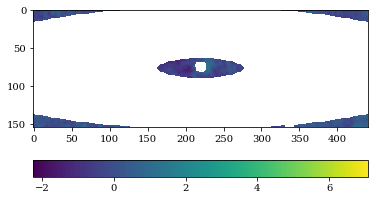

In [94]:
#use this one for 3e29 no center mask
for sigmav_limr, sigmav_lim, b in zip(sigmav_lim_real, sigmav_lims, b_sim):
    for sigmavlimr_mask, sigmavlim_mask, thickness, this_mask in zip(sigmav_limr, sigmav_lim, mask_thicknesses, mask_set):
        fig=plt.figure()
        for i in range(num_z):
            plt.plot(mx_set_out, sigmavlim_mask[:,i], label='z = '+str(z_scores[i]))
        plt.plot(mx_set_out, sigmavlimr_mask, label='data', color='k')
        ax = plt.gca()
        ax.set_ylim([10**(-27), 10**(-23)])
        plt.title(r'mask thickness $= '+ str(np.round(thickness, 4)) + r'\;\rm{rad} \;\;$' + r'with '+b + r'; D_0 = '\
                  + str(D0_set_out[0]) + ' cm^2/s' + ' no center mask')
        plt.ylabel(r'$\langle \sigma v\rangle \;\rm{(cm^3/s)}$', size=16)
        plt.xlabel(r'$m_\chi \;\rm{(GeV)}$', size=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        fig = plt.figure()
        plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax=np.max(data))
        plt.colorbar(orientation='horizontal')

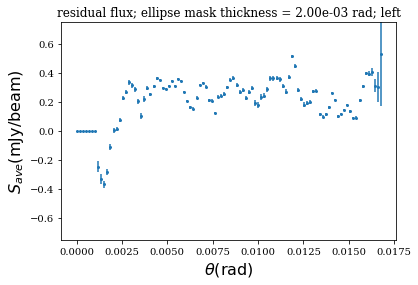

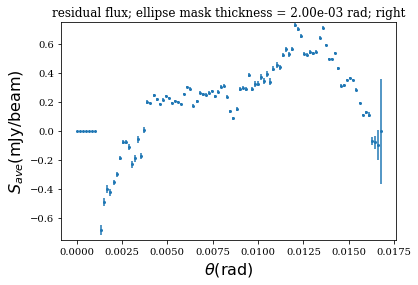

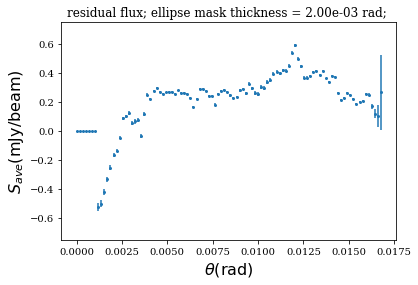

In [78]:
omega_pix = dlt_N*dlt_n
pix_per_beam = omega_beam/omega_pix
min_pix = pix_per_beam/2
m_ind = 1
mask_set_new =[]
mask_type = ['left', 'right', '']
mask_thicknesses_new = np.linspace(0, .01, 6)
for t in mask_type:
    mask_set_new.append([])
    for thickness in mask_thicknesses_new:
        this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, coords=(AX_N, AX_n), ellipse_params=[ell_params[1], ell_params[2], thickness], \
                        method='ellipse_and_azimuthally_sym', rl=t)
        mask_set_new[-1].append(this_mask)
for k in range(len(mask_type)):
    this_mask = mask_set_new[k][m_ind]
    num_bins = 100
    th_bins = np.linspace(0, np.max(THETA), num_bins+1)
    flux_bin = np.zeros(num_bins)
    pix_bin = np.zeros(num_bins)
    er_flux = np.zeros(num_bins)

    for i in range(num_bins):
        bool_bin = np.logical_and(THETA>=th_bins[i], THETA<th_bins[i+1])
        pix_bin[i] = np.sum(bool_bin*this_mask)
        flux_bin[i] = np.sum(data*bool_bin*this_mask)

    er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
               for i in range(num_bins)])
    mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
    er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
    fig = plt.figure()
    plt.scatter(th_bins[0:-1], mean_bin, s=4)
    plt.errorbar(th_bins[0:-1], mean_bin, yerr=er_beam, fmt='none')
    ax = plt.gca()
    ax.set_ylim([-0.75, 0.75])
    plt.xlabel(r'$\theta \rm{(rad)}$', size=16)
    plt.ylabel(r'$S_{ave} \rm{(mJy/beam)}$', size=16)
    plt.title(r'residual flux; ellipse mask thickness = '+ '{:.2e}'.format(mask_thicknesses_new[m_ind]) + r' rad; ' + mask_type[k])

[0 1 0]


TypeError: only integer scalar arrays can be converted to a scalar index

In [262]:
mx_set_out

array([  6. ,   7.6,   9.6,  12.1,  15.2,  19.2,  24.3,  30.6,  38.6,
        48.8,  61.5,  77.7,  98. , 123.7, 156.1, 197.1, 248.7, 313.9,
       396.2, 500. ])

In [275]:
num_bins

100

In [300]:
#compare to gaussian CLb heatmap
ch_CLb_heatmap = np.array([CLb_heatmap[ch_bsim][ch_ma][ind] for ind in ch_mx])

[[0.00000000e+00 0.00000000e+00 5.49015716e-07 0.00000000e+00
  3.84437963e-06 5.20280052e-06 3.69964544e-05 3.34878492e-04
  1.94203544e-03 7.89900818e-03 2.42016151e-02 5.90899298e-02
  1.20176188e-01 2.10806461e-01 3.27788088e-01 4.61632268e-01
  5.98962812e-01 7.25908166e-01 8.31305513e-01 9.08954414e-01
  9.58522684e-01 9.84889754e-01 9.95913798e-01 9.99256416e-01
  9.99919613e-01 9.99995583e-01 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.0000